In [2]:
import cv2 as cv # Computer vision
import numpy as np # Math and arrays
import matplotlib.pyplot as plt # Plot
import os # Directories
import time # Time measurement
import onnx # Open neural network exchange
import tf2onnx # .h5 to .onnx
import pandas as pd # Dataframes
import tensorflow as tf # Deep learning API
from tensorflow.keras.models import Sequential, Model, load_model # Model types and save/load model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, Dropout # Layers
from keras.initializers import glorot_uniform # Weights and bias initializer
from tensorflow.keras import initializers
from keras.regularizers import l2 # Regularizer
from tensorflow.keras.callbacks import LearningRateScheduler # Variable learning step
from tensorflow.keras.preprocessing import image # Image preprocsessing
from sklearn.cluster import KMeans # Cluster
import tensorflow.keras.backend as K # Low level operations
import seaborn as sns # Heatmap
from sklearn.metrics import confusion_matrix # Confusion matrix

## Table of Contents
* [Preprocessing](#Preprocessing)
    * [Data paths](#Data_paths)
        * [Dataframe](#Data_df)
            * [Create](#Create_data_df)
            * [Fill](#Fill_data_df)
                * [Bounding boxes](#Bounding_boxes_data_df)
                * [Paths](#Paths_data_df)
            * [Result](#Result_data_df)
    * [Resizing](#Resizing)
    * [Load_the_data](#Load_the_data)
        * [Visualize](#Visualize_data)
        * [Load](#Load_data)
        * [Split](#Split_data)
* [Model building](#Model_building)
    * [Image Classifier Network](#ICN)
        * [Architecture](#Architecture_ICN)
        * [Train](#Train_ICN)
        * [Performance](#Performance_ICN)
        * [Test](#Test_ICN)
            * [Confusion matrix](#Confusion_matrix_ICN)
        * [Save](#Save_ICN)
            * [Save in onnx format](#Save_ICN_onnx)
        * [Load](#Load_ICN)
    * [Feature Extraction Network](#FEN)
        * [Load](#Load_FEN)
        * [Feature maps](#Feature_maps_FEN)
    * [Detector Head Network](#DHN)
        * [Load](#Load_DHN)
    * [Region Proposal Network](#Region_Proposal_Network)
        * [Anchor boxes](#Anchor_boxes)
            * [Anchor centers](#Anchor_centers)
            * [Anchor_boxes_generation](#Anchor_boxes_generation)
            * [Valid anchor boxes](#Valid_anchor_boxes)
        * [IOU](#IOU)
        * [Objectness score](#Objectness_score)
        * [Dataframe](#Dataframe_RPN)
            * [Create](#Create_DF)
            * [Fill](#Fill_DF)
                * [Ground truth boxes](#Ground_truth_boxes_DF)
                * [Anchor boxes](#Anchor_boxes_DF)
                * [IOU and objectness score](#IOU_and_objectness_score_DF)
                * [Aboxes offset](#Aboxes_offset_DF)
            * [Result](#Result_DF)
        * [Mini batch training](#Mini_batch_training)
            * [Balance labels](#Balance_labels)
            * [Label list](#Label_list)
            * [Offset list](#Offset_list)
        * [Architecture](#Architecture_RPN)

In [2]:
# Connect the webcam
cap = cv.VideoCapture(0)
while True:
    ret,img = cap.read()
    font = cv.FONT_HERSHEY_SIMPLEX
    resize = tf.image.resize(img, (256,256))
    cv.putText(img, 
                "Hola", 
                (50, 50), 
                font, 2, 
                (0, 0, 0), 
                3, 
                cv.LINE_4)
    cv.imshow('webcam',img)
    key = cv.waitKey(10)
    if key == 27: # 27 is Esc key
        break;
cap.release()
cv.destroyAllWindows()

# Preprocessing <a class = "anchor" id = "Preprocessing"></a>

## Data paths <a class = "anchor" id = "Data_paths"></a>

In [3]:
# Raw images
odir_imgs = "C:/Users/lokit/OneDrive/Escritorio/hu/practica/primser/ObjectDetection/data_original"
# Resized images path
rdir_imgs = "C:/Users/lokit/OneDrive/Escritorio/hu/practica/primser/ObjectDetection/data_resized"

In [4]:
classes = os.listdir(odir_imgs)
classes

['start', 'stop']

In [5]:
os.listdir(odir_imgs+"/"+classes[0])

['start (1).jpg',
 'start (10).jpg',
 'start (100).jpg',
 'start (101).jpg',
 'start (102).jpg',
 'start (103).jpg',
 'start (104).jpg',
 'start (105).jpg',
 'start (106).jpg',
 'start (107).jpg',
 'start (108).jpg',
 'start (109).jpg',
 'start (11).jpg',
 'start (110).jpg',
 'start (111).jpg',
 'start (112).jpg',
 'start (113).jpg',
 'start (114).jpg',
 'start (115).jpg',
 'start (116).jpg',
 'start (117).jpg',
 'start (118).jpg',
 'start (119).jpg',
 'start (12).jpg',
 'start (120).jpg',
 'start (121).jpg',
 'start (122).jpg',
 'start (123).jpg',
 'start (124).jpg',
 'start (125).jpg',
 'start (126).jpg',
 'start (127).jpg',
 'start (128).jpg',
 'start (129).jpg',
 'start (13).jpg',
 'start (130).jpg',
 'start (131).jpg',
 'start (132).jpg',
 'start (133).jpg',
 'start (134).jpg',
 'start (135).jpg',
 'start (136).jpg',
 'start (137).jpg',
 'start (138).jpg',
 'start (139).jpg',
 'start (14).jpg',
 'start (140).jpg',
 'start (141).jpg',
 'start (142).jpg',
 'start (143).jpg',
 'start

In [6]:
# Bounding boxes, normalized format (class, xc, yc, w, h)
dir_bboxes = "C:/Users/lokit/OneDrive/Escritorio/hu/practica/primser/ObjectDetection/OpenLabeling/main/output/YOLO_darknet"

In [7]:
os.listdir(dir_bboxes)

['start (1).txt',
 'start (10).txt',
 'start (100).txt',
 'start (101).txt',
 'start (102).txt',
 'start (103).txt',
 'start (104).txt',
 'start (105).txt',
 'start (106).txt',
 'start (107).txt',
 'start (108).txt',
 'start (109).txt',
 'start (11).txt',
 'start (110).txt',
 'start (111).txt',
 'start (112).txt',
 'start (113).txt',
 'start (114).txt',
 'start (115).txt',
 'start (116).txt',
 'start (117).txt',
 'start (118).txt',
 'start (119).txt',
 'start (12).txt',
 'start (120).txt',
 'start (121).txt',
 'start (122).txt',
 'start (123).txt',
 'start (124).txt',
 'start (125).txt',
 'start (126).txt',
 'start (127).txt',
 'start (128).txt',
 'start (129).txt',
 'start (13).txt',
 'start (130).txt',
 'start (131).txt',
 'start (132).txt',
 'start (133).txt',
 'start (134).txt',
 'start (135).txt',
 'start (136).txt',
 'start (137).txt',
 'start (138).txt',
 'start (139).txt',
 'start (14).txt',
 'start (140).txt',
 'start (141).txt',
 'start (142).txt',
 'start (143).txt',
 'start

### Dataframe <a class = "anchor" id = "Data_df"></a>

#### Create <a class = "anchor" id = "Create_data_df"></a>

In [8]:
img_names = os.listdir(rdir_imgs+"/start")+os.listdir(rdir_imgs+"/stop")
img_names = np.array([img_name.strip(".jpg") for img_name in img_names])

In [9]:
idxs = img_names
cols = ["class", "xc", "yc", "w", "h", "x1", "y1", "x2", "y2", "resized img path", "bbox path"]
data_df = pd.DataFrame(index = idxs, columns = cols)
data_df["resized img path"] = np.char.add(img_names, ".jpg")
data_df["bbox path"] = np.char.add(img_names, ".txt")
data_df

,class,xc,yc,w,h,x1,y1,x2,y2,resized img path,bbox path
start (1),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,start (1).jpg,start (1).txt
start (10),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,start (10).jpg,start (10).txt
start (100),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,start (100).jpg,start (100).txt
start (101),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,start (101).jpg,start (101).txt
start (102),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,start (102).jpg,start (102).txt
...,...,...,...,...,...,...,...,...,...,...,...
stop (95),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,stop (95).jpg,stop (95).txt
stop (96),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,stop (96).jpg,stop (96).txt
stop (97),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,stop (97).jpg,stop (97).txt
stop (98),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,stop (98).jpg,stop (98).txt


#### Fill <a class = "anchor" id = "Fill_data_df"></a>

##### Bounding boxes <a class = "anchor" id = "Bounding_boxes_data_df"></a>

In [10]:
img_size = 256 # Expected image size
for img_name in img_names:
    bbox_path = dir_bboxes+"/"+img_name+".txt"
    with open(bbox_path, "r") as bbox_file:
        class_bbox = np.array(bbox_file.readline().split(" "), dtype = "float32")
    c = class_bbox[0]
    bbox = class_bbox[1:]*img_size
    data_df.loc[img_name, "class"] = c
    data_df.loc[img_name, ["xc", "yc", "w", "h"]] = bbox

In [11]:
data_df["x1"] = data_df["xc"]-data_df["w"]/2
data_df["y1"] = data_df["yc"]-data_df["h"]/2
data_df["x2"] = data_df["xc"]+data_df["w"]/2
data_df["y2"] = data_df["yc"]+data_df["h"]/2

##### Paths <a class = "anchor" id = "Paths_data_df"></a>

In [12]:
# Start
# Image paths
mask = data_df["class"] == 0
data_df.loc[mask, "resized img path"] = np.char.add(rdir_imgs+"/start/", data_df.loc[mask, "resized img path"].values.astype(str))
# Bounding box paths
data_df.loc[mask, "bbox path"] = np.char.add(dir_bboxes+"/", data_df.loc[mask, "bbox path"].values.astype(str))

# Stop
# Image paths
mask = data_df["class"] == 1
data_df.loc[mask, "resized img path"] = np.char.add(rdir_imgs+"/start/", data_df.loc[mask, "resized img path"].values.astype(str))
# Bounding box paths
data_df.loc[mask, "bbox path"] = np.char.add(dir_bboxes+"/", data_df.loc[mask, "bbox path"].values.astype(str))

#### Result <a class = "anchor" id = "Result_data_df"></a>

In [13]:
data_df

,class,xc,yc,w,h,x1,y1,x2,y2,resized img path,bbox path
start (1),0.0,119.86441,158.843369,90.033897,74.024094,74.847462,121.831322,164.881359,195.855415,C:/Users/lokit/OneDrive/Escritorio/hu/practica...,C:/Users/lokit/OneDrive/Escritorio/hu/practica...
start (10),0.0,129.066666,137.884445,108.800003,136.391113,74.666664,69.688889,183.466667,206.080002,C:/Users/lokit/OneDrive/Escritorio/hu/practica...,C:/Users/lokit/OneDrive/Escritorio/hu/practica...
start (100),0.0,193.100006,159.288895,43.0,124.444443,171.600006,97.066673,214.600006,221.511116,C:/Users/lokit/OneDrive/Escritorio/hu/practica...,C:/Users/lokit/OneDrive/Escritorio/hu/practica...
start (101),0.0,219.399994,145.066666,54.400002,124.444443,192.199993,82.844444,246.599995,207.288887,C:/Users/lokit/OneDrive/Escritorio/hu/practica...,C:/Users/lokit/OneDrive/Escritorio/hu/practica...
start (102),0.0,223.300003,176.35556,44.599998,136.53334,201.000004,108.08889,245.600002,244.622231,C:/Users/lokit/OneDrive/Escritorio/hu/practica...,C:/Users/lokit/OneDrive/Escritorio/hu/practica...
...,...,...,...,...,...,...,...,...,...,...,...
stop (95),1.0,105.599998,145.955551,43.200001,130.488892,83.999998,80.711105,127.199999,211.199997,C:/Users/lokit/OneDrive/Escritorio/hu/practica...,C:/Users/lokit/OneDrive/Escritorio/hu/practica...
stop (96),1.0,85.099998,134.222229,39.799999,121.955559,65.199999,73.24445,104.999998,195.200008,C:/Users/lokit/OneDrive/Escritorio/hu/practica...,C:/Users/lokit/OneDrive/Escritorio/hu/practica...
stop (97),1.0,143.5,122.311111,46.200001,137.244446,120.4,53.688889,166.6,190.933334,C:/Users/lokit/OneDrive/Escritorio/hu/practica...,C:/Users/lokit/OneDrive/Escritorio/hu/practica...
stop (98),1.0,164.399994,113.422226,48.400002,133.688889,140.199993,46.577782,188.599995,180.26667,C:/Users/lokit/OneDrive/Escritorio/hu/practica...,C:/Users/lokit/OneDrive/Escritorio/hu/practica...


## Resizing <a class = "anchor" id = "Resizing"></a>

In [27]:
# Resize images and save to new folder ("data_resized")
# As the bounding boxes values are normalized, they don´t need to be resized 
def resize_imgs(new_size, odir_imgs):
    for folder in os.listdir(odir_imgs):
        for img_filename in os.listdir(odir_imgs+"/"+folder):
            img_path = odir_imgs+"/"+folder+"/"+img_filename
            img = cv.imread(img_path)
            img = cv.resize(img, (new_size, new_size))
            resized_img_path = img_path.replace("original","resized")
            cv.imwrite(resized_img_path, img)

In [28]:
tic = time.time()
new_size = 256
resize_imgs(new_size, odir_imgs)
tac = time.time()
print(tac-tic)

36.3356511592865


## Load the data <a class = "anchor" id = "Load_the_data"></a>

### Visualize <a class = "anchor" id = "Visualize_data"></a>

In [20]:
def plot_img_w_bbox(data_df, filename):
    img = cv.imread(data_df.loc[filename, "resized img path"])
    x1 = int(data_df.loc[filename, ["x1"]][0])
    x2 = int(data_df.loc[filename, ["x2"]][0])
    y1 = int(data_df.loc[filename, ["y1"]][0])
    y2 = int(data_df.loc[filename, ["y2"]][0])
    color = (0,0, 255)
    thickness = 2
    cv.rectangle(img, (x1, y1), (x2, y2), color, thickness)
    fig = plt.figure(facecolor = 'white')
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))    
    fig.suptitle(filename, fontsize = 20)

In [22]:
import faster_rcnn_fncs import plot_img_w_bbox

In [28]:
faster_rcnn_fncs

<module 'faster_rcnn_fncs' (namespace)>

In [25]:
filename = "start (1)"
faster_rcnn_fncs.plot_img_w_bbox(data_df, filename)

AttributeError: module 'faster_rcnn_fncs' has no attribute 'plot_img_w_bbox'

### Load <a class = "anchor" id = "Load_data"></a>

In [22]:
data = tf.keras.utils.image_dataset_from_directory(rdir_imgs, batch_size = 32, image_size = (256, 256))

Found 709 files belonging to 2 classes.


In [23]:
data.class_names

['start', 'stop']

In [24]:
# Scalate data (pixel value from 0 to 255)
data = data.map(lambda x, y: (x/255, y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [25]:
data_iterator = data.as_numpy_iterator()

In [26]:
batch = data_iterator.next()

In [27]:
batch[0].max()

1.0

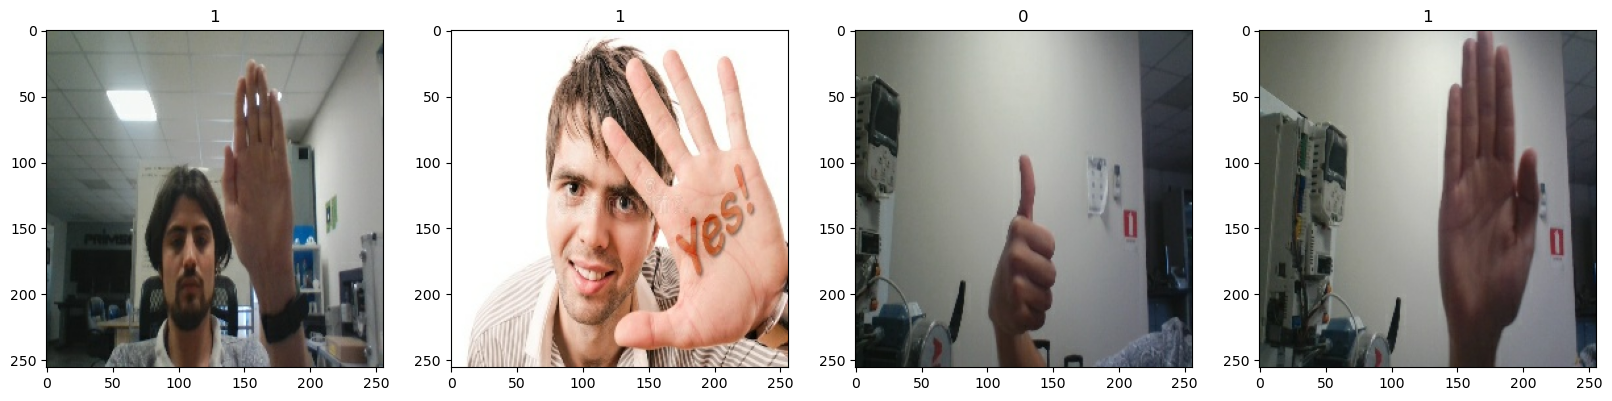

In [28]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

### Split <a class = "anchor" id = "Split_data"></a>

In [29]:
len(data)

23

In [30]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)
train_size,val_size,test_size,train_size+val_size+test_size,len(data)

(16, 5, 2, 23, 23)

In [31]:
train = data.take(train_size)
val = data.take(val_size)
test = data.take(test_size)

In [209]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
base_dir = rdir_imgs

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
#     shear_range = 0.2,
#     zoom_range = 0.2,
#     horizontal_flip = True,
    validation_split = 0.3
    )

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
     rescale = 1./255,
     validation_split = 0.3
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
     rescale = 1./255,
)

train_datagen = train_datagen.flow_from_directory(
    base_dir,
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    subset = 'training'
)

val_datagen = val_datagen.flow_from_directory(
    base_dir,
    target_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    subset = 'validation'
)

test_datagen = test_datagen.flow_from_directory(
    base_dir,
    target_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE,
)

Found 497 images belonging to 2 classes.
Found 212 images belonging to 2 classes.
Found 709 images belonging to 2 classes.


# Model building <a class = "anchor" id = "Model_building"></a>

## Image classifier network <a class = "anchor" id = "ICN"></a>
###### a.k.a ICN

### Architecture <a class = "anchor" id = "Architecture_ICN"></a>

In [386]:
ICN = Sequential(name = "ICN")

In [387]:
# 1) Conv2D 1
ICN.add(Conv2D(
               4,
               kernel_size = (3, 3),
               padding = "same",
               activation = 'relu',
               input_shape = (256, 256, 3),
               #kernel_regularizer = l2(0.01),
               name = "C1_ICN")
       )
# 2) MaxPooling2D 1
ICN.add(MaxPooling2D(
                     pool_size = (2, 2),
                     name = "MP1_ICN")
       )
# 3) Conv2D 2
ICN.add(Conv2D(
               8,
               kernel_size = (3, 3),
               padding = "same",
               activation = 'relu',
               #kernel_regularizer = l2(0.01),
               name = "C2_ICN")
       )
# 4) MaxPooling2D 2
ICN.add(MaxPooling2D(
                     pool_size = (2, 2),
                     name = "MP2_ICN")
       )
# 5) Conv2D 3
ICN.add(Conv2D(
               16,
               kernel_size = (3, 3),
               padding = "same",
               activation = 'relu',
               #kernel_regularizer = l2(0.01),
               name = "C3_ICN")
       )
# 6) MaxPooling2D 3
ICN.add(MaxPooling2D(
                     pool_size = (2, 2),
                     name = "MP3_ICN")
       )
# 7) Conv2D 4
ICN.add(Conv2D(
               32,
               kernel_size = (3, 3),
               padding = "same",
               activation = 'relu',
               #kernel_regularizer = l2(0.01),
               name = "C4_ICN")
       )
# 8) MaxPooling2D 4
ICN.add(MaxPooling2D(
                     pool_size = (2, 2),
                     name = "MP4_ICN")
       )
# Dropout 1
# ICN.add(Dropout(
#                 0.5,
#                 name = "DO1_ICN")
#        )

# 9) Flatten 1
ICN.add(Flatten(
                name = "F_ICN")
       )
# 10) Dense 1
ICN.add(Dense(
              256,
              activation = 'relu',
              #kernel_initializer = glorot_uniform(seed = 0),
              #kernel_regularizer = l2(0.01),
              name = "D1_ICN")
       )
# Dropout 2
# ICN.add(Dropout(
#                 0.5,
#                 name = "DO2_ICN")
#        )

# 11) Dense 2
ICN.add(Dense(
              len(classes),
              activation = "softmax",
              #kernel_initializer = glorot_uniform(seed = 0),
              #kernel_regularizer = l2(0.01),
              name = "D2_ICN")
       )

In [388]:
ICN.compile(optimizer = 'adam',
            loss = "categorical_crossentropy",
            metrics = ['accuracy']
           )

In [389]:
ICN.summary()

Model: "ICN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1_ICN (Conv2D)             (None, 256, 256, 4)       112       
                                                                 
 MP1_ICN (MaxPooling2D)      (None, 128, 128, 4)       0         
                                                                 
 C2_ICN (Conv2D)             (None, 128, 128, 8)       296       
                                                                 
 MP2_ICN (MaxPooling2D)      (None, 64, 64, 8)         0         
                                                                 
 C3_ICN (Conv2D)             (None, 64, 64, 16)        1168      
                                                                 
 MP3_ICN (MaxPooling2D)      (None, 32, 32, 16)        0         
                                                                 
 C4_ICN (Conv2D)             (None, 32, 32, 32)        4640    

### Train <a class = "anchor" id = "Train_ICN"></a>

In [390]:
logdir_ICN = 'logs/logs_ICN'

In [391]:
tensorboard_callback_ICN = tf.keras.callbacks.TensorBoard(log_dir = logdir_ICN)

In [393]:
def scheduler(epoch):
    if epoch < 10:
        return 0.01
    else:
        return 0.001*tf.math.exp(0.1*(10-epoch))
learning_rate = LearningRateScheduler(scheduler)

In [394]:
hist_ICN = ICN.fit(train_datagen,
                   epochs = 15,
                   validation_data = val_datagen,
                   callbacks = [tensorboard_callback_ICN, learning_rate])

Epoch 1/15
16/16 [==============================] - 9s 507ms/step - loss: 1.0994 - accuracy: 0.5070 - val_loss: 0.6955 - val_accuracy: 0.5047 - lr: 0.0100
Epoch 2/15
16/16 [==============================] - 8s 488ms/step - loss: 0.6662 - accuracy: 0.5775 - val_loss: 0.8153 - val_accuracy: 0.4151 - lr: 0.0100
Epoch 3/15
16/16 [==============================] - 8s 491ms/step - loss: 0.4676 - accuracy: 0.7686 - val_loss: 0.9971 - val_accuracy: 0.5094 - lr: 0.0100
Epoch 4/15
16/16 [==============================] - 8s 493ms/step - loss: 0.3388 - accuracy: 0.8471 - val_loss: 0.5238 - val_accuracy: 0.7264 - lr: 0.0100
Epoch 5/15
16/16 [==============================] - 8s 479ms/step - loss: 0.2165 - accuracy: 0.9054 - val_loss: 0.4378 - val_accuracy: 0.7594 - lr: 0.0100
Epoch 6/15
16/16 [==============================] - 8s 509ms/step - loss: 0.1350 - accuracy: 0.9316 - val_loss: 0.8378 - val_accuracy: 0.7453 - lr: 0.0100
Epoch 7/15
16/16 [==============================] - 8s 476ms/step - lo

### Performance <a class = "anchor" id = "Performance_ICN"></a>

In [372]:
def plot_loss_and_accuracy(hist):
    fig, ax = plt.subplots(ncols = 2, figsize = (10,5))
    # Loss
    ax[0].plot(hist.history['loss'], color = 'teal', label = 'loss')
    ax[0].plot(hist.history['val_loss'], color = 'orange', label = 'val_loss')
    ax[0].title.set_text('Loss')
    ax[0].legend(loc = 'upper right')
    # Accuracy
    ax[1].plot(hist.history['accuracy'], color = 'teal', label = 'accuracy')
    ax[1].plot(hist.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
    ax[1].title.set_text('Accuracy')
    ax[1].legend(loc = 'lower right')

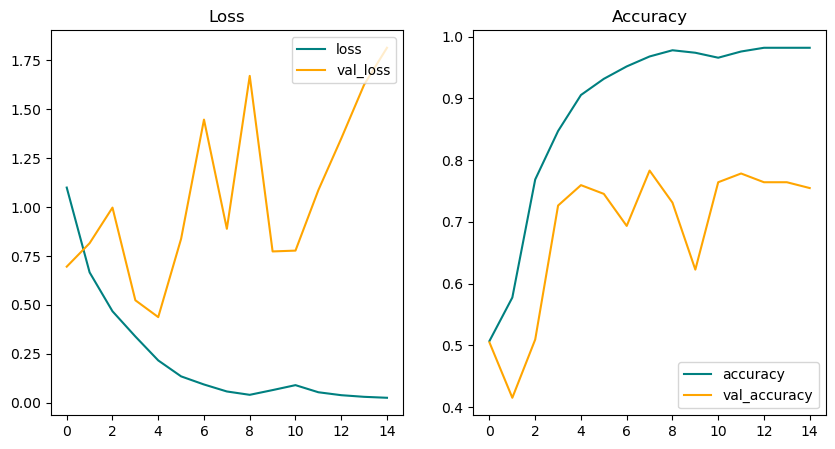

In [395]:
plot_loss_and_accuracy(hist_ICN)

### Test <a class = "anchor" id = "Test_ICN"></a>

In [374]:
def get_predicted_class(yhat):
    idx = np.where(yhat[0] == yhat[0].max())[0][0]
    if idx == 0:
        return str(round(100*yhat[0].max(), 2))+" % START"
    elif idx == 1:
        return str(round(100*yhat[0].max(), 2))+" % STOP"

In [396]:
yhat = ICN.predict(np.expand_dims(img/255, 0))
yhat

1/1 [==============================] - 0s 89ms/step


array([[0.00996452, 0.9900355 ]], dtype=float32)

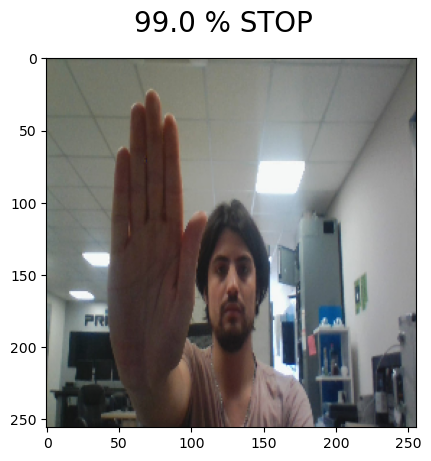

In [397]:
img = cv.imread("C:/Users/lokit/OneDrive/Escritorio/hu/practica/primser/seguridadML/images/testing/stop.jpg")
img = cv.resize(img, (256, 256))
plt.figure(facecolor = 'white')
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB));
plt.suptitle(get_predicted_class(yhat), fontsize = 20);

In [452]:
# Connect the webcam
cap = cv.VideoCapture(0)
while True:
    ret,img = cap.read()
    img = cv.resize(img, (256,256))
    yhat = ICN.predict(np.expand_dims(img/255, 0))
    img = cv.resize(img, (800, 800))
    font = cv.FONT_HERSHEY_SIMPLEX
    text = get_predicted_class(yhat)
    cv.putText(img, 
                str(int(100*round(yhat[0].max(),2)))+'% '+text, 
                (50, 50), 
                font, 2, 
                (0, 0, 0), 
                3, 
                cv.LINE_4)
    cv.imshow('webcam', img)
    key = cv.waitKey(10)
    if key == 27: # 27 is Esc key
        break;
cap.release()
cv.destroyAllWindows()

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 29ms/step


#### Confusion matrix  <a class = "anchor" id = "Confusion_matrix_ICN"></a>

In [359]:
def plot_confusion_matrix(model, test_data):
    y_pred = model.predict(test_data)
    y_pred_classes = np.argmax(y_pred, axis = 1)
    y_true = test_data.labels
    cm = confusion_matrix(y_true, y_pred_classes)
    sns.heatmap(cm, annot = True, fmt = 'g', cmap = 'Blues')
    [[TN, FP], [FN, TP]] = cm
    acc = round(100*TP/(TP+FP), 2) # Accuracy
    rec = round(100*TP/(TP+FN), 2) # Recall
    spe = round(100*TN/(TN+FP), 2) # Specificity
    plt.suptitle("Accuracy = {} %, Recall = {} %, Specificity = {} %".format(acc,rec,spe))
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

23/23 [==============================] - 4s 175ms/step


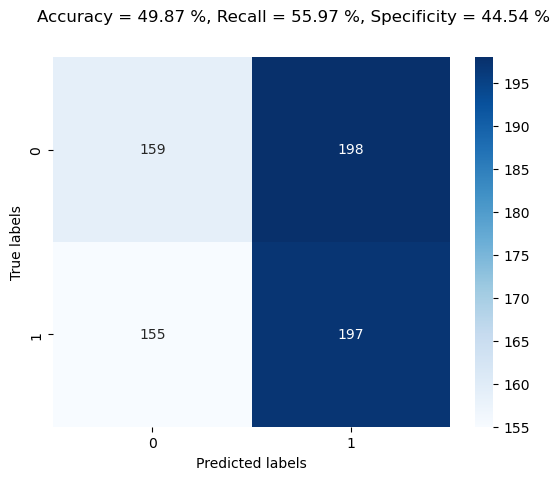

In [401]:
plot_confusion_matrix(ICN, test_datagen)

### Save <a class = "anchor" id = "Save_ICN"></a>

In [403]:
ICN.save(os.path.join('models', 'ICN.h5'))

#### Save in onnx format <a class = "anchor" id = "Save_ICN_onnx"></a>
###### To load the network in Wolfram (layer visualization)

In [404]:
# Convierte el modelo a ONNX
ICN_onnx, _ = tf2onnx.convert.from_keras(ICN)

# Guarda el modelo en un archivo ONNX
with open('models\\ICN.onnx', 'wb') as f:
    f.write(ICN_onnx.SerializeToString())

### Load <a class = "anchor" id = "Load_ICN"></a>

In [361]:
ICN = tf.keras.models.load_model("models\\ICN.h5")

## Feature extraction network <a class = "anchor" id = "FEN"></a>
###### a.k.a FEN

In [405]:
output_layer_name = 'C4_ICN'
output_layer = ICN.get_layer(output_layer_name).output
FEN = Model(inputs = ICN.input, outputs = output_layer, name = "FEN")

In [406]:
FEN.summary()

Model: "FEN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1_ICN_input (InputLayer)   [(None, 256, 256, 3)]     0         
                                                                 
 C1_ICN (Conv2D)             (None, 256, 256, 4)       112       
                                                                 
 MP1_ICN (MaxPooling2D)      (None, 128, 128, 4)       0         
                                                                 
 C2_ICN (Conv2D)             (None, 128, 128, 8)       296       
                                                                 
 MP2_ICN (MaxPooling2D)      (None, 64, 64, 8)         0         
                                                                 
 C3_ICN (Conv2D)             (None, 64, 64, 16)        1168      
                                                                 
 MP3_ICN (MaxPooling2D)      (None, 32, 32, 16)        0       

### Save <a class = "anchor" id = "Save_FEN"></a>

In [30]:
FEN.save(os.path.join('models', 'FEN.h5'))

### Load <a class = "anchor" id = "Load_FEN"></a>

In [ ]:
FEN = tf.keras.models.load_model("models\\FEN.h5")

### Feature maps <a class = "anchor" id = "Feature_maps_FEN"></a>

In [417]:
def plot_feature_maps(feature_maps):
    for i in range(feature_maps.shape[3]):
        plt.figure()
        plt.imshow(feature_maps[0, :, :, i], cmap = 'gray')
        plt.axis('off')

1/1 [==============================] - 0s 27ms/step


C:\Users\lokit\AppData\Local\Temp\ipykernel_22028\3404662777.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


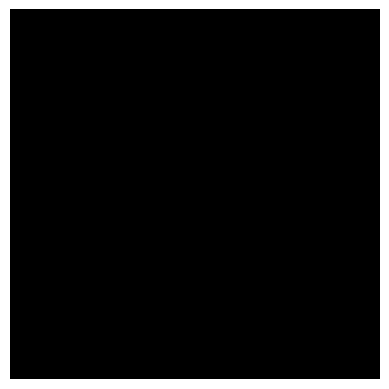

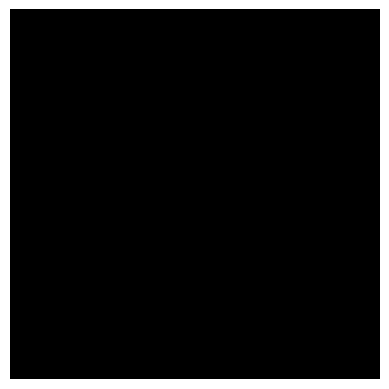

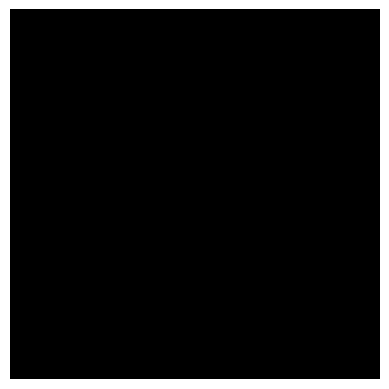

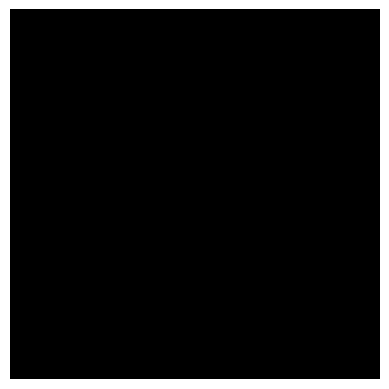

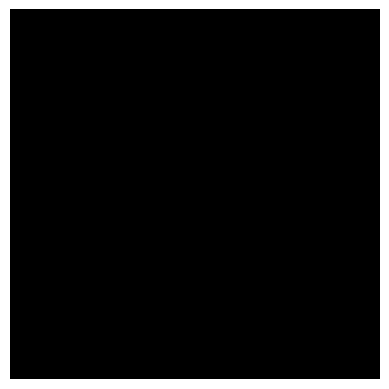

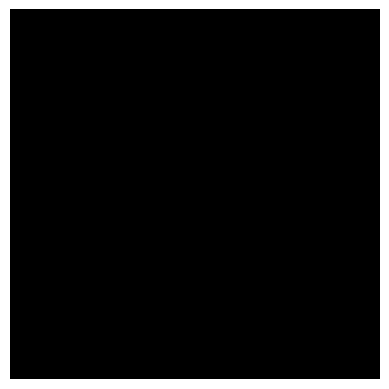

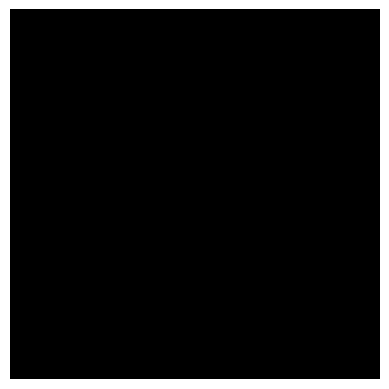

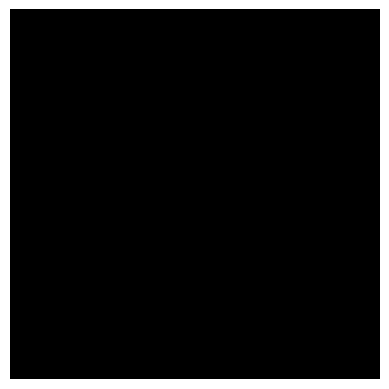

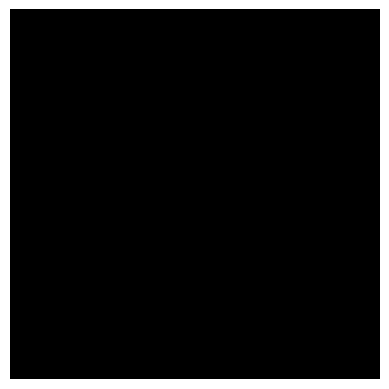

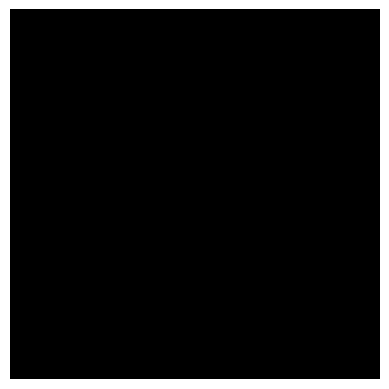

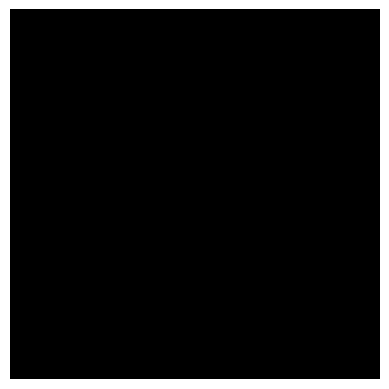

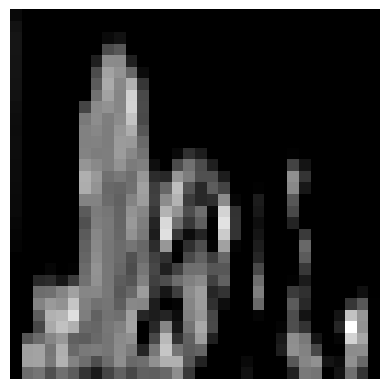

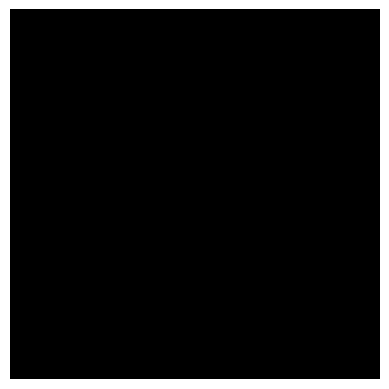

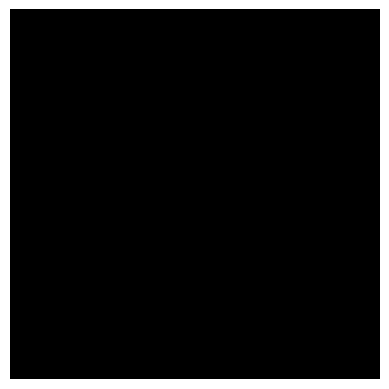

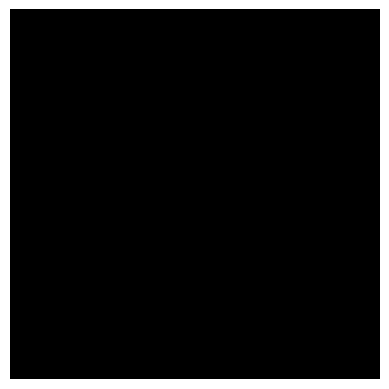

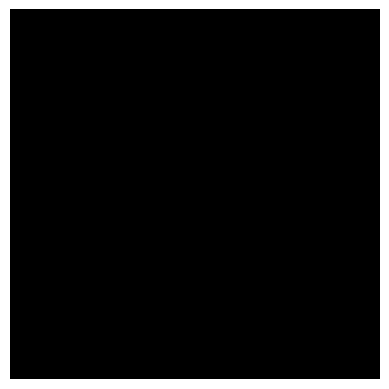

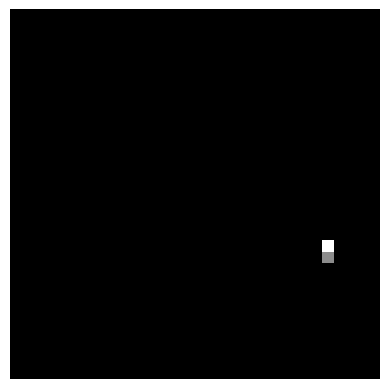

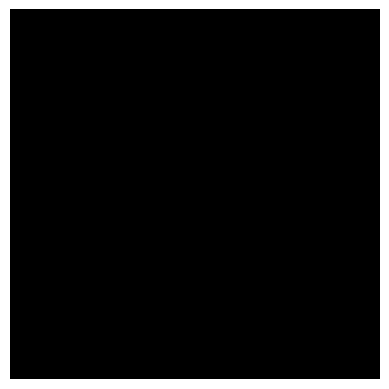

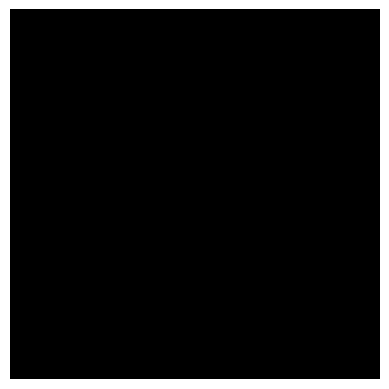

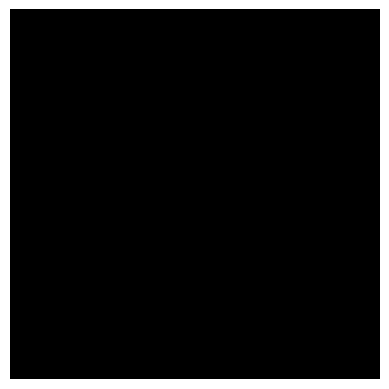

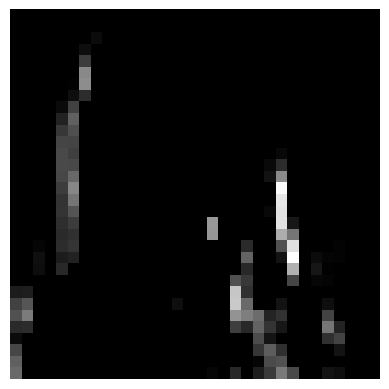

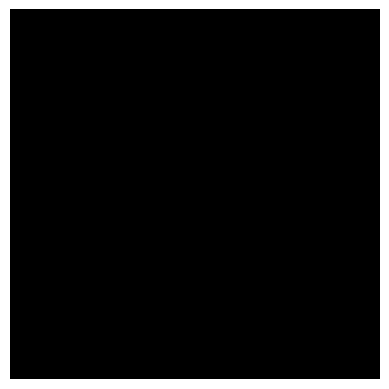

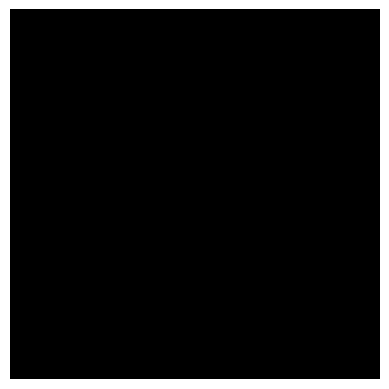

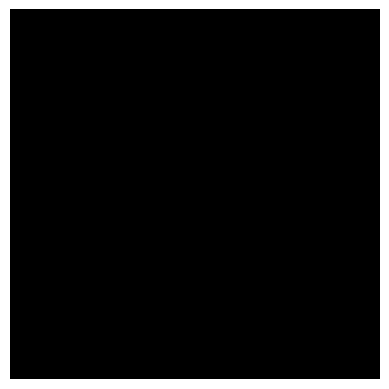

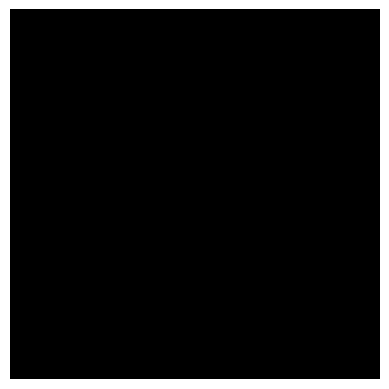

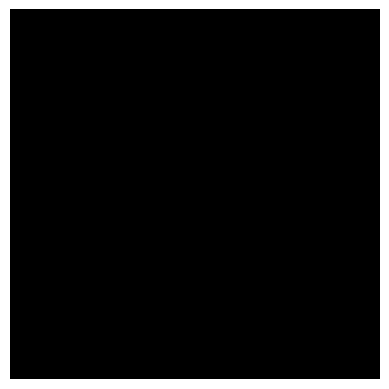

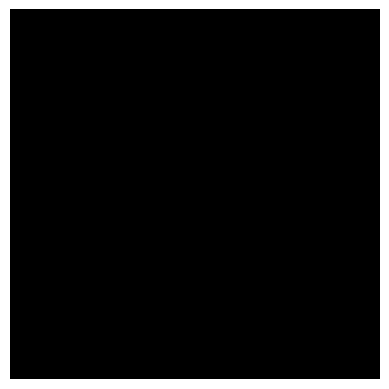

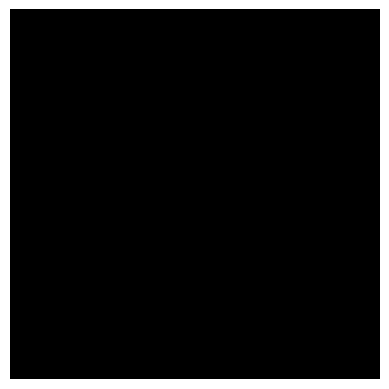

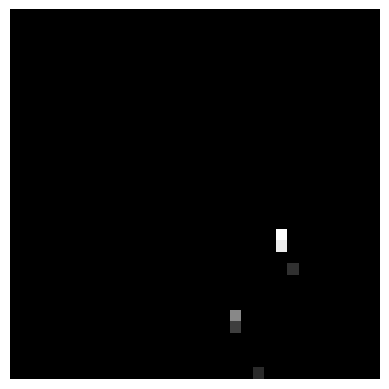

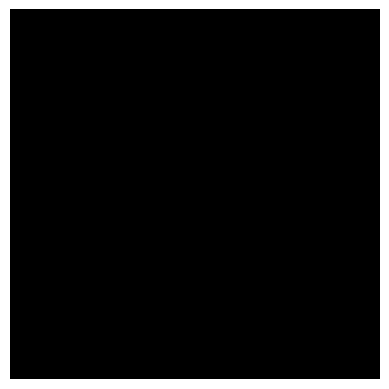

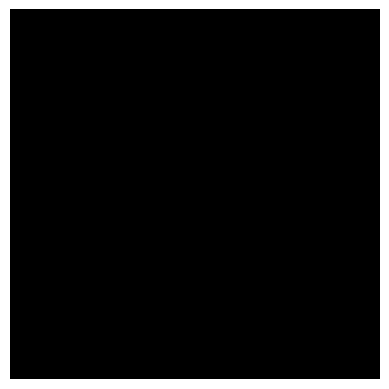

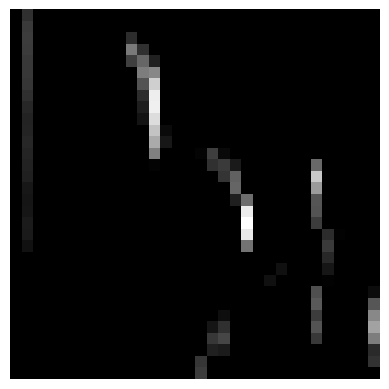

In [418]:
img = cv.imread("C:/Users/lokit/OneDrive/Escritorio/hu/practica/primser/seguridadML/images/testing/stop.jpg")
img = cv.resize(img, (256, 256))
feature_maps = FEN.predict(np.expand_dims(img/255, 0))
plot_feature_maps(feature_maps)

## Detector Head Network <a class = "anchor" id = "DHN"></a>
###### a.k.a DHN

In [419]:
DHN = Model(inputs = ICN.get_layer("C4_ICN").output, outputs = ICN.output, name = "DHN")

In [420]:
DHN.summary()

Model: "DHN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 32)]      0         
                                                                 
 MP4_ICN (MaxPooling2D)      (None, 16, 16, 32)        0         
                                                                 
 F_ICN (Flatten)             (None, 8192)              0         
                                                                 
 D1_ICN (Dense)              (None, 256)               2097408   
                                                                 
 D2_ICN (Dense)              (None, 2)                 514       
                                                                 
Total params: 2,097,922
Trainable params: 2,097,922
Non-trainable params: 0
_________________________________________________________________


### Save <a class = "anchor" id = "Save_DHN"></a>

In [35]:
DHN.save(os.path.join('models', 'DHN.h5'))

### Load <a class = "anchor" id = "Load_DHN"></a>

In [80]:
DHN = tf.keras.models.load_model("models\\DHN.h5")

## Region Proposal Network <a class = "anchor" id = "Region_Proposal_Network"></a>

### Anchor boxes <a class = "anchor" id = "Anchor_boxes"></a>
#### The input is the ouput of the feature extraction network (backbone)

#### Anchor centers <a class = "anchor" id = "Anchor_centers"></a>

In [421]:
bis = list(FEN.input.shape)[1] # Backbone input shape (fe_size en video)
bos = list(FEN.output.shape)[1] # Backbone output shape
brr = bis//bos # Backbone reduction ratio (16 en video)
(bis, bos, brr)

(256, 32, 8)

In [422]:
ctr_x = np.arange(brr, (bos+1)*brr, brr)
ctr_y = np.copy(ctr_x)
print("len(ctr_x) = "+str(len(ctr_x)))
print("ctr_x = "+str(ctr_x))
n_ac = bos**2 # Number of anchor centers
print("n_ac = "+str(n_ac))

len(ctr_x) = 32
ctr_x = [  8  16  24  32  40  48  56  64  72  80  88  96 104 112 120 128 136 144
 152 160 168 176 184 192 200 208 216 224 232 240 248 256]
n_ac = 1024


In [423]:
idx = 0
ctr = np.zeros((n_ac, 2))
for x in range(bos):
    for y in range (bos):
        ctr[idx, 1] = ctr_x[x]-4
        ctr[idx, 0] = ctr_y[y]-4
        idx += 1
print(ctr.shape)

(1024, 2)


##### Display the 1024 anchor centers

In [424]:
def plot_img_w_bbox_and_acenters(data_df, filename, ctr):
    img = cv.imread(data_df.loc[filename, "resized img path"])
    x1 = int(data_df.loc[filename, ["x1"]][0])
    x2 = int(data_df.loc[filename, ["x2"]][0])
    y1 = int(data_df.loc[filename, ["y1"]][0])
    y2 = int(data_df.loc[filename, ["y2"]][0])
    color = (0,0, 255)
    thickness = 2
    cv.rectangle(img, (x1, y1), (x2, y2), color, thickness)
    
    for i in range(ctr.shape[0]):
        cv.circle(img, (int(ctr[i][0]), int(ctr[i][1])),
                  radius = 1,
                  color = (0,0,255),
                  thickness = 1)
        
    fig = plt.figure(facecolor = 'white')
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))    
    fig.suptitle(filename, fontsize = 20)

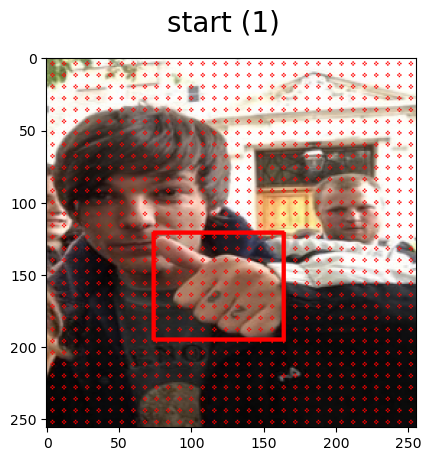

In [425]:
filename = "start (1)"
plot_img_w_bbox_and_acenters(data_df, filename, ctr)

#### Anchor boxes generation <a class = "anchor" id = "Anchor_boxes_generation"></a>

In [428]:
# Get common ratios from data anchor boxes
ratios = []
for filename in os.listdir(dir_bboxes):
    with open(dir_bboxes+"/"+filename, "r") as bbox_file:
        bbox = np.array(bbox_file.readline().split(" ")[1:])
    bbox = np.vectorize(float)(bbox)
    #print(bbox)
    x, y, w, h = np.multiply(bbox, 256)
    ratios.append(w/h)
ratios = np.array(ratios).reshape(-1,1)
kmeans = KMeans(n_clusters = 3, random_state = 0, n_init = 1)
kmeans.fit(ratios)
ratios_centroids = kmeans.cluster_centers_
ratios_centroids.tolist()

C:\Users\lokit\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


[[0.36100760671257515], [1.12516617689688], [0.6493107898987295]]

In [429]:
ratios_centroids

array([[0.36100761],
       [1.12516618],
       [0.64931079]])

In [430]:
ratios = [0.5, 1, 2]
#ratios = ratios_centroids.tolist()
scales = [brr/2, brr, brr*2]
k = len(ratios)*len(scales)
sub_sample = brr
aboxes = np.zeros(((bos**2*len(scales)*len(ratios)), 4))
idx = 0
for c in ctr:
    ctr_y, ctr_x = c
    for i in range(len(ratios)):
        for j in range(len(scales)):
            h = sub_sample*scales[j]*np.sqrt(ratios[i])
            w = sub_sample*scales[j]*np.sqrt(1./ratios[i])
            aboxes[idx, 0] = ctr_y-h/2 # y1
            aboxes[idx, 1] = ctr_x-w/2 # x1
            aboxes[idx, 2] = ctr_y+h/2 # y2
            aboxes[idx, 3] = ctr_x+w/2 # x2
            idx +=1
print(aboxes.shape)

(9216, 4)


In [431]:
aboxes

array([[ -7.3137085 , -18.627417  ,  15.3137085 ,  26.627417  ],
       [-18.627417  , -41.254834  ,  26.627417  ,  49.254834  ],
       [-41.254834  , -86.50966799,  49.254834  ,  94.50966799],
       ...,
       [229.372583  , 240.6862915 , 274.627417  , 263.3137085 ],
       [206.745166  , 229.372583  , 297.254834  , 274.627417  ],
       [161.49033201, 206.745166  , 342.50966799, 297.254834  ]])

In [434]:
cols = ["y1", "x1", "y2", "x2"]
aboxes_df = pd.DataFrame(aboxes, columns = cols)
aboxes_df

,y1,x1,y2,x2
0,-7.313708,-18.627417,15.313708,26.627417
1,-18.627417,-41.254834,26.627417,49.254834
2,-41.254834,-86.509668,49.254834,94.509668
3,-12.000000,-12.000000,20.000000,20.000000
4,-28.000000,-28.000000,36.000000,36.000000
...,...,...,...,...
9211,220.000000,220.000000,284.000000,284.000000
9212,188.000000,188.000000,316.000000,316.000000
9213,229.372583,240.686292,274.627417,263.313708
9214,206.745166,229.372583,297.254834,274.627417


In [439]:
aboxes_df["xc"] = (aboxes_df["x1"]+aboxes_df["x2"])/2
aboxes_df["yc"] = (aboxes_df["y1"]+aboxes_df["y2"])/2
aboxes_df["w"] = aboxes_df["x2"]-aboxes_df["x1"]
aboxes_df["h"] = aboxes_df["y2"]-aboxes_df["y1"]

In [440]:
aboxes_df

,y1,x1,y2,x2,xc,yc,w,h
0,-7.313708,-18.627417,15.313708,26.627417,4.0,4.0,45.254834,22.627417
1,-18.627417,-41.254834,26.627417,49.254834,4.0,4.0,90.509668,45.254834
2,-41.254834,-86.509668,49.254834,94.509668,4.0,4.0,181.019336,90.509668
3,-12.000000,-12.000000,20.000000,20.000000,4.0,4.0,32.000000,32.000000
4,-28.000000,-28.000000,36.000000,36.000000,4.0,4.0,64.000000,64.000000
...,...,...,...,...,...,...,...,...
9211,220.000000,220.000000,284.000000,284.000000,252.0,252.0,64.000000,64.000000
9212,188.000000,188.000000,316.000000,316.000000,252.0,252.0,128.000000,128.000000
9213,229.372583,240.686292,274.627417,263.313708,252.0,252.0,22.627417,45.254834
9214,206.745166,229.372583,297.254834,274.627417,252.0,252.0,45.254834,90.509668


#### Valid anchor boxes <a class = "anchor" id = "Valid_anchor_boxes"></a>
##### Exclude all the anchor boxes with coordinates outside the image

In [443]:
idx_inside = np.where((aboxes[:, 0] >= 0) &
                      (aboxes[:, 1] >= 0) &
                      (aboxes[:, 2] <= 255) &
                      (aboxes[:, 3] <= 255))[0]
print(idx_inside.shape, idx_inside)

(4564,) [ 321  330  339 ... 8607 8610 8616]


In [444]:
valid_aboxes = aboxes[idx_inside]
valid_aboxes.shape

(4564, 4)

In [445]:
valid_aboxes.max()

254.50966799187808

In [451]:
aboxes_df["valid"] = 0
aboxes_df.loc[idx_inside, "valid"] = 1

In [449]:
aboxes_df.loc[idx_inside]

,y1,x1,y2,x2,xc,yc,w,h,valid
321,5.372583,0.686292,50.627417,23.313708,12.0,28.0,22.627417,45.254834,1
330,13.372583,0.686292,58.627417,23.313708,12.0,36.0,22.627417,45.254834,1
339,21.372583,0.686292,66.627417,23.313708,12.0,44.0,22.627417,45.254834,1
348,29.372583,0.686292,74.627417,23.313708,12.0,52.0,22.627417,45.254834,1
357,37.372583,0.686292,82.627417,23.313708,12.0,60.0,22.627417,45.254834,1
...,...,...,...,...,...,...,...,...,...
8598,204.000000,220.000000,236.000000,252.000000,236.0,220.0,32.000000,32.000000,1
8601,197.372583,224.686292,242.627417,247.313708,236.0,220.0,22.627417,45.254834,1
8607,212.000000,220.000000,244.000000,252.000000,236.0,228.0,32.000000,32.000000,1
8610,205.372583,224.686292,250.627417,247.313708,236.0,228.0,22.627417,45.254834,1


##### Display anchor boxes and the ground truth box

In [43]:
def plot_img_w_bbox_and_aboxes(img_path, bbox_path, abox_start, abox_stop, flag = ""):
    # Image
    img = cv.imread(img_path)
    img_name = img_path.split("/")[-1].strip(".jpg")
    # Ground truth box
    with open(bbox_path, "r") as bbox_file:
        bbox = np.array(bbox_file.readline().split(" ")[1:])
    bbox = np.vectorize(float)(bbox)
    H, W = np.array(img).shape[:2]
    x, y, w, h = np.multiply(bbox,np.array([W, H]*2))
    x1 = int(x-w/2)
    x2 = int(x+w/2)
    y1 = int(y-h/2)
    y2 = int(y+h/2)
    cv.rectangle(img, (x1, y1), (x2, y2), color = (0,0, 255), thickness = 2)
    # Anchor boxes
    if flag == "v":
        for i in range(abox_start, abox_stop):
            y1 = int(valid_aboxes[i][0])
            x1 = int(valid_aboxes[i][1])
            y2 = int(valid_aboxes[i][2])
            x2 = int(valid_aboxes[i][3])
            cv.rectangle(img, (x1, y1), (x2, y2), color = (100, 255, 0), thickness = 1)
    else:
        for i in range(abox_start, abox_stop):
            y1 = int(aboxes[i][0])
            x1 = int(aboxes[i][1])
            y2 = int(aboxes[i][2])
            x2 = int(aboxes[i][3])
            cv.rectangle(img, (x1, y1), (x2, y2), color = (100, 255, 0), thickness = 1)
    
    fig = plt.figure(facecolor = 'white')
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))    
    fig.suptitle(img_name,fontsize = 20)

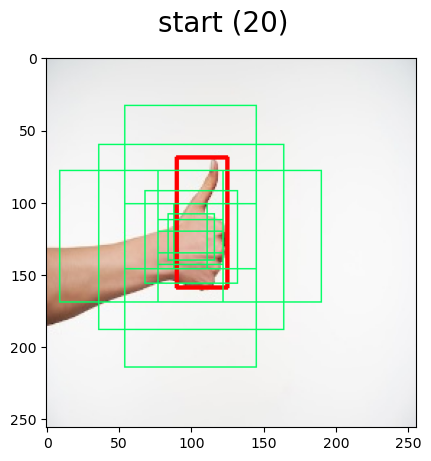

In [44]:
img_name = "start (20)"
img_path = rdir_imgs+"/start/"+img_name+".jpg"
bbox_path = dir_bboxes+"/"+img_name+".txt"
plot_img_w_bbox_and_aboxes(img_path, bbox_path, 1590, 1600, "v")

### IOU <a class = "anchor" id = "IOU"></a>
##### Calculate IOU of valid anchor boxes

In [45]:
def iou_calculator(bbox_path, valid_aboxes = valid_aboxes):
    with open(bbox_path, "r") as bbox_file:
        bbox = np.array(bbox_file.readline().split(" ")[1:])
    bbox = np.vectorize(float)(bbox)
    x, y, w, h = np.multiply(bbox, 256)
    xb1 = x1 = x-w/2
    xb2 = x2 = x+w/2
    yb1 = y1 = y-h/2
    yb2 = y2 = y+h/2
    b_area = (yb2-yb1)*(xb2-xb1)
    ious = np.empty((len(valid_aboxes), 1), dtype = np.float32)
    ious.fill(0)
    for num1, i in enumerate(valid_aboxes):
        ya1, xa1, ya2, xa2 = i
        a_area = (ya2-ya1)*(xa2-xa1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2-inter_y1)*(inter_x2-inter_x1)
            iou = iter_area/(a_area+b_area-iter_area)
        else:
            iou = 0
        ious[num1] = iou
    return ious

In [46]:
img_name = "start (20)"
bbox_path = dir_bboxes+"/"+img_name+".txt"
ious = iou_calculator(bbox_path)
ious

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [47]:
def plot_aboxes_filtered_by_iou(img_path, bbox_path, ious, iou_threshold):
    # Image
    img = cv.imread(img_path)
    img_name = img_path.split("/")[-1].strip(".jpg")
    # Ground truth box
    with open(bbox_path, "r") as bbox_file:
        bbox = np.array(bbox_file.readline().split(" ")[1:])
    bbox = np.vectorize(float)(bbox)
    x, y, w, h = np.multiply(bbox, 256)
    x1 = int(x-w/2)
    x2 = int(x+w/2)
    y1 = int(y-h/2)
    y2 = int(y+h/2)
    cv.rectangle(img, (x1, y1), (x2, y2), color = (0,0, 255), thickness = 2)
    # Anchor boxes
    idxs = np.where(ious > iou_threshold)[0]
    for idx in idxs.tolist():
        y1 = int(valid_aboxes[idx][0])
        x1 = int(valid_aboxes[idx][1])
        y2 = int(valid_aboxes[idx][2])
        x2 = int(valid_aboxes[idx][3])
        cv.rectangle(img, (x1, y1), (x2, y2), color = (100, 255, 0), thickness = 1)
    
    fig = plt.figure(facecolor = 'white')
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))    
    fig.suptitle(img_name,fontsize = 20)

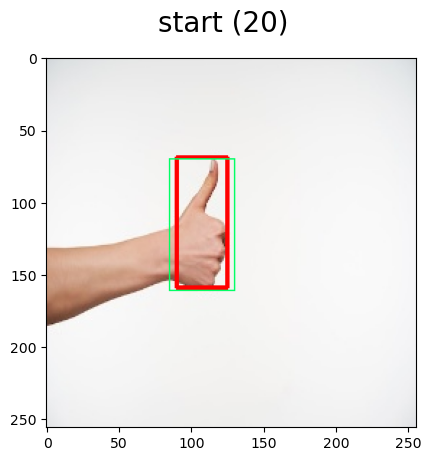

In [48]:
img_name = "start (20)"
img_path = rdir_imgs+"/start/"+img_name+".jpg"
bbox_path = dir_bboxes+"/"+img_name+".txt"
plot_aboxes_filtered_by_iou(img_path, bbox_path, ious, 0.7)

In [49]:
np.where(ious > 0.7)[0]

array([1787], dtype=int64)

In [50]:
# Which anchor box has max iou with ground truth box (only one)
gt_argmax_ious = ious.argmax(axis = 0)
print(gt_argmax_ious)
gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print(gt_max_ious)

[1787]
[0.754177]


In [51]:
# Which ground truth box is associated with each anchor box
# if n_bbox in the image > 1
argmax_ious = ious.argmax(axis = 1)
print(argmax_ious.shape)
print(argmax_ious)
max_ious = ious[np.arange(len(idx_inside)), argmax_ious]
print(max_ious)

(4564,)
[0 0 0 ... 0 0 0]
[0. 0. 0. ... 0. 0. 0.]


### Objectness score <a class = "anchor" id = "Objectness_score"></a>
##### 1: object
##### 0: background
##### -1: ignore

In [52]:
def objectness_score(ious, pos_iou_threshold = 0.7, neg_iou_threshold = 0.3):
    label = np.empty((len(ious), ), dtype = np.int32)
    label.fill(-1)
    gt_argmax_ious = ious.argmax(axis = 0)
    argmax_ious = ious.argmax(axis = 1)
    max_ious = ious[np.arange(len(ious)), argmax_ious]
    label[gt_argmax_ious] = 1 # At least one positive anchor box for each image
    label[max_ious >= pos_iou_threshold] = 1
    label[max_ious <= neg_iou_threshold] = 0
    return label

In [53]:
label = objectness_score(ious)
np.count_nonzero(label == 1), label.shape

(1, (4564,))

### Dataframe <a class = "anchor" id = "Dataframe_RPN"></a>

#### Create <a class = "anchor" id = "Create_DF"></a>

In [54]:
img_names = os.listdir(rdir_imgs+"/start")+os.listdir(rdir_imgs+"/stop")
img_names = [img_name.strip(".jpg") for img_name in img_names]
idxs_valid_aboxes = list(range(valid_aboxes.shape[0]))

In [55]:
idxs = pd.MultiIndex.from_product([img_names, idxs_valid_aboxes], names = ["img name", "valid abox id"])
cols = ["abox id", "iou", "label", "gtbox xc", "gtbox yc", "gtbox w", "gtbox h", "abox xc", "abox yc", "abox w", "abox h", "dx", "dy", "dw", "dh"]
df = pd.DataFrame(index = idxs, columns = cols)
df["abox id"] = idx_inside.tolist()*len(img_names)
df["label"] = -1

In [56]:
df

abox id  iou  label gtbox xc gtbox yc gtbox w  \
img name  valid abox id                                                  
start (1) 0                  321  NaN     -1      NaN      NaN     NaN   
          1                  330  NaN     -1      NaN      NaN     NaN   
          2                  339  NaN     -1      NaN      NaN     NaN   
          3                  348  NaN     -1      NaN      NaN     NaN   
          4                  357  NaN     -1      NaN      NaN     NaN   
...                          ...  ...    ...      ...      ...     ...   
stop (99) 4559              8598  NaN     -1      NaN      NaN     NaN   
          4560              8601  NaN     -1      NaN      NaN     NaN   
          4561              8607  NaN     -1      NaN      NaN     NaN   
          4562              8610  NaN     -1      NaN      NaN     NaN   
          4563              8616  NaN     -1      NaN      NaN     NaN   

                        gtbox h abox xc abox yc abox w abox h   dx   dy   dw  \
img name  valid abox id                                                        
start (1) 0                 NaN     NaN     NaN    NaN    NaN  NaN  NaN  NaN   
          1                 NaN     NaN     NaN    NaN    NaN  NaN  NaN  NaN   
          2                 NaN     NaN     NaN    NaN    NaN  NaN  NaN  NaN   
          3                 NaN     NaN     NaN    NaN    NaN  NaN  NaN  NaN   
          4                 NaN     NaN     NaN    NaN    NaN  NaN  NaN  NaN   
...                         ...     ...     ...    ...    ...  ...  ...  ...   
stop (99) 4559              NaN     NaN     NaN    NaN    NaN  NaN  NaN  NaN   
          4560              NaN     NaN     NaN    NaN    NaN  NaN  NaN  NaN   
          4561              NaN     NaN     NaN    NaN    NaN  NaN  NaN  NaN   
          4562              NaN     NaN     NaN    NaN    NaN  NaN  NaN  NaN   
          4563              NaN     NaN     NaN    NaN    NaN  NaN  NaN  NaN   

                          dh  
img name  valid abox id       
start (1) 0              NaN  
          1              NaN  
          2              NaN  
          3              NaN  
          4              NaN  
...                      ...  
stop (99) 4559           NaN  
          4560           NaN  
          4561           NaN  
          4562           NaN  
          4563           NaN  

[3235876 rows x 15 columns]

#### Fill <a class = "anchor" id = "Fill_DF"></a>

##### Ground truth boxes <a class = "anchor" id = "Ground_truth_boxes_DF"></a>

In [57]:
tic = time.time()
for idx0 in df.index.get_level_values(0).drop_duplicates():
    with open(dir_bboxes+"/"+idx0+".txt", "r") as bbox_file:
        bbox = np.array(bbox_file.readline().split(" ")[1:])
    bbox = np.vectorize(float)(bbox)
    xc, yc, w, h = np.multiply(bbox, 256)
    df.loc[idx0, "gtbox xc"] = xc
    df.loc[idx0, "gtbox yc"] = yc
    df.loc[idx0, "gtbox w"] = w
    df.loc[idx0, "gtbox h"] = h
tac = time.time()
tac-tic

25.2399959564209

##### Anchor boxes <a class = "anchor" id = "Anchor_boxes_DF"></a>

In [58]:
tic = time.time()
y1 = np.array([abox[0] for abox in valid_aboxes])
x1 = np.array([abox[1] for abox in valid_aboxes])
y2 = np.array([abox[2] for abox in valid_aboxes])
x2 = np.array([abox[3] for abox in valid_aboxes])
xc = (x1+x2)/2
yc = (y1+y2)/2
w = x2-x1
h = y2-y1
df["abox xc"] = xc.tolist()*len(img_names)
df["abox yc"] = yc.tolist()*len(img_names)
df["abox w"] = w.tolist()*len(img_names)
df["abox h"] = h.tolist()*len(img_names)
tac = time.time()
tac-tic

2.0585381984710693

##### IOU and objectness score <a class = "anchor" id = "IOU_and_objectness_score_DF"></a>

In [59]:
# Iou and objetcness score with masks
tic = time.time()
for img_name in img_names:
    df.loc[(img_name, slice(None)), "iou"] = iou_calculator(dir_bboxes+"/"+img_name+".txt")
mask = df["iou"] >= 0.7
df.loc[mask, "label"] = 1
mask = df["iou"] <= 0.3
df.loc[mask, "label"] = 0
tac = time.time()
tac-tic

42.33584642410278

In [146]:
# Iou and objetcness score with objectness_score function
tic = time.time()
for img_name in img_names:
    ious = iou_calculator(dir_bboxes+"/"+img_name+".txt")
    df.loc[(img_name, slice(None)), "iou"] = ious
    df.loc[(img_name, slice(None)), "label"] = objectness_score(ious)
tac = time.time()
tac-tic

78.72782492637634

###### It takes the half of the time to assign objectness score (label) with masks (aprox. 60s) than using objectness_score function (aprox 130 s), and the result is the same

##### Aboxes offset <a class = "anchor" id = "Aboxes_offset_DF"></a>

In [60]:
df["dx"] = (df["gtbox xc"]-df["abox xc"])/df["abox w"]
df["dy"] = (df["gtbox yc"]-df["abox yc"])/df["abox h"]
df["dw"] = np.log((df["gtbox w"]/df["abox w"]).astype(float))
df["dh"] = np.log((df["gtbox h"]/df["abox h"]).astype(float))

#### Result <a class = "anchor" id = "Result_DF"></a>

In [61]:
df[cols[3:]] = df[cols[3:]].values.astype("float32")

In [62]:
df

abox id  iou  label   gtbox xc    gtbox yc  \
img name  valid abox id                                               
start (1) 0                  321  0.0      0  119.86441  158.843369   
          1                  330  0.0      0  119.86441  158.843369   
          2                  339  0.0      0  119.86441  158.843369   
          3                  348  0.0      0  119.86441  158.843369   
          4                  357  0.0      0  119.86441  158.843369   
...                          ...  ...    ...        ...         ...   
stop (99) 4559              8598  0.0      0  112.00000  139.911118   
          4560              8601  0.0      0  112.00000  139.911118   
          4561              8607  0.0      0  112.00000  139.911118   
          4562              8610  0.0      0  112.00000  139.911118   
          4563              8616  0.0      0  112.00000  139.911118   

                           gtbox w     gtbox h  abox xc  abox yc     abox w  \
img name  valid abox id                                                       
start (1) 0              90.033897   74.024094     12.0     28.0  22.627417   
          1              90.033897   74.024094     12.0     36.0  22.627417   
          2              90.033897   74.024094     12.0     44.0  22.627417   
          3              90.033897   74.024094     12.0     52.0  22.627417   
          4              90.033897   74.024094     12.0     60.0  22.627417   
...                            ...         ...      ...      ...        ...   
stop (99) 4559           36.000000  145.422226    236.0    220.0  32.000000   
          4560           36.000000  145.422226    236.0    220.0  22.627417   
          4561           36.000000  145.422226    236.0    228.0  32.000000   
          4562           36.000000  145.422226    236.0    228.0  22.627417   
          4563           36.000000  145.422226    236.0    236.0  32.000000   

                            abox h        dx        dy        dw        dh  
img name  valid abox id                                                     
start (1) 0              45.254833  4.766978  2.891257  1.381024  0.492081  
          1              45.254833  4.766978  2.714481  1.381024  0.492081  
          2              45.254833  4.766978  2.537704  1.381024  0.492081  
          3              45.254833  4.766978  2.360927  1.381024  0.492081  
          4              45.254833  4.766978  2.184151  1.381024  0.492081  
...                            ...       ...       ...       ...       ...  
stop (99) 4559           32.000000 -3.875000 -2.502778  0.117783  1.513906  
          4560           45.254833 -5.480078 -1.769731  0.464357  1.167332  
          4561           32.000000 -3.875000 -2.752778  0.117783  1.513906  
          4562           45.254833 -5.480078 -1.946508  0.464357  1.167332  
          4563           32.000000 -3.875000 -3.002778  0.117783  1.513906  

[3235876 rows x 15 columns]

In [63]:
mask = df["label"] == 1
df.loc[mask] #1588

abox id       iou  label    gtbox xc    gtbox yc  \
img name   valid abox id                                                     
start (10) 2002              4181  0.742512      1  129.066666  137.884445   
           2011              4190  0.759986      1  129.066666  137.884445   
           2020              4199  0.700224      1  129.066666  137.884445   
           2192              4460  0.701443      1  129.066666  137.884445   
           2201              4469  0.786161      1  129.066666  137.884445   
...                           ...       ...    ...         ...         ...   
stop (80)  1833              3923   0.70125      1  107.400002  144.711105   
           1842              3932   0.70125      1  107.400002  144.711105   
stop (9)   865               2462  0.717898      1   72.064003  139.130432   
           1044              2750  0.717898      1   72.064003  139.130432   
           1223              3038  0.717898      1   72.064003  139.130432   

                             gtbox w     gtbox h  abox xc  abox yc  \
img name   valid abox id                                             
start (10) 2002           108.800003  136.391113    116.0    132.0   
           2011           108.800003  136.391113    116.0    140.0   
           2020           108.800003  136.391113    116.0    148.0   
           2192           108.800003  136.391113    124.0    124.0   
           2201           108.800003  136.391113    124.0    132.0   
...                              ...         ...      ...      ...   
stop (80)  1833            86.400002  132.977783    108.0    156.0   
           1842            86.400002  132.977783    108.0    164.0   
stop (9)   865             95.487999  134.716644     68.0    140.0   
           1044            95.487999  134.716644     76.0    140.0   
           1223            95.487999  134.716644     84.0    140.0   

                              abox w      abox h        dx        dy  \
img name   valid abox id                                               
start (10) 2002           128.000000  128.000000  0.102083  0.045972   
           2011           128.000000  128.000000  0.102083 -0.016528   
           2020           128.000000  128.000000  0.102083 -0.079028   
           2192           128.000000  128.000000  0.039583  0.108472   
           2201           128.000000  128.000000  0.039583  0.045972   
...                              ...         ...       ...       ...   
stop (80)  1833            90.509666  181.019333 -0.006629 -0.062363   
           1842            90.509666  181.019333 -0.006629 -0.106557   
stop (9)   865            128.000000  128.000000  0.031750 -0.006793   
           1044           128.000000  128.000000 -0.030750 -0.006793   
           1223           128.000000  128.000000 -0.093250 -0.006793   

                                dw        dh  
img name   valid abox id                      
start (10) 2002          -0.162519  0.063496  
           2011          -0.162519  0.063496  
           2020          -0.162519  0.063496  
           2192          -0.162519  0.063496  
           2201          -0.162519  0.063496  
...                            ...       ...  
stop (80)  1833          -0.046469 -0.308422  
           1842          -0.046469 -0.308422  
stop (9)   865           -0.293030  0.051143  
           1044          -0.293030  0.051143  
           1223          -0.293030  0.051143  

[1588 rows x 15 columns]

In [64]:
mask = df["label"] == 0
df.loc[mask] #309907

abox id  iou  label   gtbox xc    gtbox yc  \
img name  valid abox id                                               
start (1) 0                  321  0.0      0  119.86441  158.843369   
          1                  330  0.0      0  119.86441  158.843369   
          2                  339  0.0      0  119.86441  158.843369   
          3                  348  0.0      0  119.86441  158.843369   
          4                  357  0.0      0  119.86441  158.843369   
...                          ...  ...    ...        ...         ...   
stop (99) 4559              8598  0.0      0  112.00000  139.911118   
          4560              8601  0.0      0  112.00000  139.911118   
          4561              8607  0.0      0  112.00000  139.911118   
          4562              8610  0.0      0  112.00000  139.911118   
          4563              8616  0.0      0  112.00000  139.911118   

                           gtbox w     gtbox h  abox xc  abox yc     abox w  \
img name  valid abox id                                                       
start (1) 0              90.033897   74.024094     12.0     28.0  22.627417   
          1              90.033897   74.024094     12.0     36.0  22.627417   
          2              90.033897   74.024094     12.0     44.0  22.627417   
          3              90.033897   74.024094     12.0     52.0  22.627417   
          4              90.033897   74.024094     12.0     60.0  22.627417   
...                            ...         ...      ...      ...        ...   
stop (99) 4559           36.000000  145.422226    236.0    220.0  32.000000   
          4560           36.000000  145.422226    236.0    220.0  22.627417   
          4561           36.000000  145.422226    236.0    228.0  32.000000   
          4562           36.000000  145.422226    236.0    228.0  22.627417   
          4563           36.000000  145.422226    236.0    236.0  32.000000   

                            abox h        dx        dy        dw        dh  
img name  valid abox id                                                     
start (1) 0              45.254833  4.766978  2.891257  1.381024  0.492081  
          1              45.254833  4.766978  2.714481  1.381024  0.492081  
          2              45.254833  4.766978  2.537704  1.381024  0.492081  
          3              45.254833  4.766978  2.360927  1.381024  0.492081  
          4              45.254833  4.766978  2.184151  1.381024  0.492081  
...                            ...       ...       ...       ...       ...  
stop (99) 4559           32.000000 -3.875000 -2.502778  0.117783  1.513906  
          4560           45.254833 -5.480078 -1.769731  0.464357  1.167332  
          4561           32.000000 -3.875000 -2.752778  0.117783  1.513906  
          4562           45.254833 -5.480078 -1.946508  0.464357  1.167332  
          4563           32.000000 -3.875000 -3.002778  0.117783  1.513906  

[3099077 rows x 15 columns]

In [65]:
mask = df["label"] == -1
df.loc[mask] #135211

abox id       iou  label   gtbox xc    gtbox yc  \
img name  valid abox id                                                    
start (1) 1215              3029  0.307087     -1  119.86441  158.843369   
          1223              3038  0.307087     -1  119.86441  158.843369   
          1231              3047  0.307087     -1  119.86441  158.843369   
          1238              3055  0.324079     -1  119.86441  158.843369   
          1239              3056  0.307087     -1  119.86441  158.843369   
...                          ...       ...    ...        ...         ...   
stop (99) 2593              5039  0.310861     -1  112.00000  139.911118   
          2602              5048  0.310861     -1  112.00000  139.911118   
          2611              5057  0.310861     -1  112.00000  139.911118   
          2620              5066  0.310861     -1  112.00000  139.911118   
          2629              5075  0.310861     -1  112.00000  139.911118   

                           gtbox w     gtbox h  abox xc  abox yc      abox w  \
img name  valid abox id                                                        
start (1) 1215           90.033897   74.024094     84.0    132.0  128.000000   
          1223           90.033897   74.024094     84.0    140.0  128.000000   
          1231           90.033897   74.024094     84.0    148.0  128.000000   
          1238           90.033897   74.024094     84.0    156.0   64.000000   
          1239           90.033897   74.024094     84.0    156.0  128.000000   
...                            ...         ...      ...      ...         ...   
stop (99) 2593           36.000000  145.422226    140.0    124.0   90.509666   
          2602           36.000000  145.422226    140.0    132.0   90.509666   
          2611           36.000000  145.422226    140.0    140.0   90.509666   
          2620           36.000000  145.422226    140.0    148.0   90.509666   
          2629           36.000000  145.422226    140.0    156.0   90.509666   

                             abox h        dx        dy        dw        dh  
img name  valid abox id                                                      
start (1) 1215           128.000000  0.280191  0.209714 -0.351844 -0.547640  
          1223           128.000000  0.280191  0.147214 -0.351844 -0.547640  
          1231           128.000000  0.280191  0.084714 -0.351844 -0.547640  
          1238            64.000000  0.560381  0.044428  0.341303  0.145508  
          1239           128.000000  0.280191  0.022214 -0.351844 -0.547640  
...                             ...       ...       ...       ...       ...  
stop (99) 2593           181.019333 -0.309359  0.087897 -0.921938 -0.218962  
          2602           181.019333 -0.309359  0.043703 -0.921938 -0.218962  
          2611           181.019333 -0.309359 -0.000491 -0.921938 -0.218962  
          2620           181.019333 -0.309359 -0.044685 -0.921938 -0.218962  
          2629           181.019333 -0.309359 -0.088879 -0.921938 -0.218962  

[135211 rows x 15 columns]

### Mini batch training <a class = "Mini batch training" id = "Mini_batch_training"></a>
###### 256 valid anchor boxes
###### Ideal:
###### 128 positive examples (objectness score == 1)
###### 128 negative examples (objectness score == 0)

#### Balance labels <a class = "anchor" id = "Balance_labels"></a>

In [66]:
def balance_labels(df, n_samples = 256, neg_ratio = 0.5):
    # Sample total of n samples across both the class (background and foreground),
    # if one of the class have less samples than n/2,
    # we will sample from majority class to make up for short.
    n_obj = int((1-neg_ratio) * n_samples)
    n_back = int(neg_ratio * n_samples)
    obj_idxs = df[df.label == 1].index.values
    back_idxs = df[df.label == 0].index.values

    # check if we have excessive positive samples
    if len(obj_idxs) > n_obj:
        # mark excessive samples as -1 (ignore)
        ignore_idx = np.random.choice(obj_idxs, size = len(obj_idxs)-n_obj, replace = False)
        df.loc[ignore_idx, "label"] = -1

    # sample background examples if we don't have enough positive examples to match the anchor batch size
    if len(obj_idxs) < n_obj:
        diff = n_obj - len(obj_idxs)
        # add remaining to background examples
        n_back += diff

    # check if we have excessive background samples
    if len(back_idxs) > n_back:
        # mark excessive samples as -1 (ignore)
        ignore_idx = np.random.choice(back_idxs, size = len(back_idxs)-n_back, replace = False)
        df.loc[ignore_idx, "label"] = -1

In [67]:
tic = time.time()
for idx0 in df.index.get_level_values(0).drop_duplicates():
    balance_labels(df.loc[idx0])
tac = time.time()
tac-tic

7.323447942733765

In [68]:
df

abox id  iou  label   gtbox xc    gtbox yc  \
img name  valid abox id                                               
start (1) 0                  321  0.0     -1  119.86441  158.843369   
          1                  330  0.0     -1  119.86441  158.843369   
          2                  339  0.0     -1  119.86441  158.843369   
          3                  348  0.0     -1  119.86441  158.843369   
          4                  357  0.0     -1  119.86441  158.843369   
...                          ...  ...    ...        ...         ...   
stop (99) 4559              8598  0.0     -1  112.00000  139.911118   
          4560              8601  0.0     -1  112.00000  139.911118   
          4561              8607  0.0     -1  112.00000  139.911118   
          4562              8610  0.0     -1  112.00000  139.911118   
          4563              8616  0.0     -1  112.00000  139.911118   

                           gtbox w     gtbox h  abox xc  abox yc     abox w  \
img name  valid abox id                                                       
start (1) 0              90.033897   74.024094     12.0     28.0  22.627417   
          1              90.033897   74.024094     12.0     36.0  22.627417   
          2              90.033897   74.024094     12.0     44.0  22.627417   
          3              90.033897   74.024094     12.0     52.0  22.627417   
          4              90.033897   74.024094     12.0     60.0  22.627417   
...                            ...         ...      ...      ...        ...   
stop (99) 4559           36.000000  145.422226    236.0    220.0  32.000000   
          4560           36.000000  145.422226    236.0    220.0  22.627417   
          4561           36.000000  145.422226    236.0    228.0  32.000000   
          4562           36.000000  145.422226    236.0    228.0  22.627417   
          4563           36.000000  145.422226    236.0    236.0  32.000000   

                            abox h        dx        dy        dw        dh  
img name  valid abox id                                                     
start (1) 0              45.254833  4.766978  2.891257  1.381024  0.492081  
          1              45.254833  4.766978  2.714481  1.381024  0.492081  
          2              45.254833  4.766978  2.537704  1.381024  0.492081  
          3              45.254833  4.766978  2.360927  1.381024  0.492081  
          4              45.254833  4.766978  2.184151  1.381024  0.492081  
...                            ...       ...       ...       ...       ...  
stop (99) 4559           32.000000 -3.875000 -2.502778  0.117783  1.513906  
          4560           45.254833 -5.480078 -1.769731  0.464357  1.167332  
          4561           32.000000 -3.875000 -2.752778  0.117783  1.513906  
          4562           45.254833 -5.480078 -1.946508  0.464357  1.167332  
          4563           32.000000 -3.875000 -3.002778  0.117783  1.513906  

[3235876 rows x 15 columns]

In [69]:
mask = df["label"] == 1
df.loc[mask] #1588

abox id       iou  label    gtbox xc    gtbox yc  \
img name   valid abox id                                                     
start (10) 2002              4181  0.742512      1  129.066666  137.884445   
           2011              4190  0.759986      1  129.066666  137.884445   
           2020              4199  0.700224      1  129.066666  137.884445   
           2192              4460  0.701443      1  129.066666  137.884445   
           2201              4469  0.786161      1  129.066666  137.884445   
...                           ...       ...    ...         ...         ...   
stop (80)  1833              3923   0.70125      1  107.400002  144.711105   
           1842              3932   0.70125      1  107.400002  144.711105   
stop (9)   865               2462  0.717898      1   72.064003  139.130432   
           1044              2750  0.717898      1   72.064003  139.130432   
           1223              3038  0.717898      1   72.064003  139.130432   

                             gtbox w     gtbox h  abox xc  abox yc  \
img name   valid abox id                                             
start (10) 2002           108.800003  136.391113    116.0    132.0   
           2011           108.800003  136.391113    116.0    140.0   
           2020           108.800003  136.391113    116.0    148.0   
           2192           108.800003  136.391113    124.0    124.0   
           2201           108.800003  136.391113    124.0    132.0   
...                              ...         ...      ...      ...   
stop (80)  1833            86.400002  132.977783    108.0    156.0   
           1842            86.400002  132.977783    108.0    164.0   
stop (9)   865             95.487999  134.716644     68.0    140.0   
           1044            95.487999  134.716644     76.0    140.0   
           1223            95.487999  134.716644     84.0    140.0   

                              abox w      abox h        dx        dy  \
img name   valid abox id                                               
start (10) 2002           128.000000  128.000000  0.102083  0.045972   
           2011           128.000000  128.000000  0.102083 -0.016528   
           2020           128.000000  128.000000  0.102083 -0.079028   
           2192           128.000000  128.000000  0.039583  0.108472   
           2201           128.000000  128.000000  0.039583  0.045972   
...                              ...         ...       ...       ...   
stop (80)  1833            90.509666  181.019333 -0.006629 -0.062363   
           1842            90.509666  181.019333 -0.006629 -0.106557   
stop (9)   865            128.000000  128.000000  0.031750 -0.006793   
           1044           128.000000  128.000000 -0.030750 -0.006793   
           1223           128.000000  128.000000 -0.093250 -0.006793   

                                dw        dh  
img name   valid abox id                      
start (10) 2002          -0.162519  0.063496  
           2011          -0.162519  0.063496  
           2020          -0.162519  0.063496  
           2192          -0.162519  0.063496  
           2201          -0.162519  0.063496  
...                            ...       ...  
stop (80)  1833          -0.046469 -0.308422  
           1842          -0.046469 -0.308422  
stop (9)   865           -0.293030  0.051143  
           1044          -0.293030  0.051143  
           1223          -0.293030  0.051143  

[1588 rows x 15 columns]

In [70]:
mask = df["label"] == 0
df.loc[mask] #179916

abox id  iou  label   gtbox xc    gtbox yc  \
img name  valid abox id                                               
start (1) 5                  366  0.0      0  119.86441  158.843369   
          6                  375  0.0      0  119.86441  158.843369   
          8                  393  0.0      0  119.86441  158.843369   
          12                 429  0.0      0  119.86441  158.843369   
          14                 447  0.0      0  119.86441  158.843369   
...                          ...  ...    ...        ...         ...   
stop (99) 4474              8242  0.0      0  112.00000  139.911118   
          4478              8251  0.0      0  112.00000  139.911118   
          4488              8274  0.0      0  112.00000  139.911118   
          4499              8298  0.0      0  112.00000  139.911118   
          4555              8580  0.0      0  112.00000  139.911118   

                           gtbox w     gtbox h  abox xc  abox yc     abox w  \
img name  valid abox id                                                       
start (1) 5              90.033897   74.024094     12.0     68.0  22.627417   
          6              90.033897   74.024094     12.0     76.0  22.627417   
          8              90.033897   74.024094     12.0     92.0  22.627417   
          12             90.033897   74.024094     12.0    124.0  22.627417   
          14             90.033897   74.024094     12.0    140.0  22.627417   
...                            ...         ...      ...      ...        ...   
stop (99) 4474           36.000000  145.422226    228.0    156.0  45.254833   
          4478           36.000000  145.422226    228.0    164.0  45.254833   
          4488           36.000000  145.422226    228.0    188.0  32.000000   
          4499           36.000000  145.422226    228.0    212.0  45.254833   
          4555           36.000000  145.422226    236.0    204.0  32.000000   

                            abox h        dx        dy        dw        dh  
img name  valid abox id                                                     
start (1) 5              45.254833  4.766978  2.007374  1.381024  0.492081  
          6              45.254833  4.766978  1.830597  1.381024  0.492081  
          8              45.254833  4.766978  1.477044  1.381024  0.492081  
          12             45.254833  4.766978  0.769937  1.381024  0.492081  
          14             45.254833  4.766978  0.416384  1.381024  0.492081  
...                            ...       ...       ...       ...       ...  
stop (99) 4474           90.509666 -2.563262 -0.177759 -0.228791  0.474185  
          4478           90.509666 -2.563262 -0.266147 -0.228791  0.474185  
          4488           32.000000 -3.625000 -1.502778  0.117783  1.513906  
          4499           22.627417 -2.563262 -3.185909 -0.228791  1.860479  
          4555           32.000000 -3.875000 -2.002778  0.117783  1.513906  

[179916 rows x 15 columns]

In [71]:
mask = df["label"] == -1
df.loc[mask] #3054372

abox id  iou  label   gtbox xc    gtbox yc  \
img name  valid abox id                                               
start (1) 0                  321  0.0     -1  119.86441  158.843369   
          1                  330  0.0     -1  119.86441  158.843369   
          2                  339  0.0     -1  119.86441  158.843369   
          3                  348  0.0     -1  119.86441  158.843369   
          4                  357  0.0     -1  119.86441  158.843369   
...                          ...  ...    ...        ...         ...   
stop (99) 4559              8598  0.0     -1  112.00000  139.911118   
          4560              8601  0.0     -1  112.00000  139.911118   
          4561              8607  0.0     -1  112.00000  139.911118   
          4562              8610  0.0     -1  112.00000  139.911118   
          4563              8616  0.0     -1  112.00000  139.911118   

                           gtbox w     gtbox h  abox xc  abox yc     abox w  \
img name  valid abox id                                                       
start (1) 0              90.033897   74.024094     12.0     28.0  22.627417   
          1              90.033897   74.024094     12.0     36.0  22.627417   
          2              90.033897   74.024094     12.0     44.0  22.627417   
          3              90.033897   74.024094     12.0     52.0  22.627417   
          4              90.033897   74.024094     12.0     60.0  22.627417   
...                            ...         ...      ...      ...        ...   
stop (99) 4559           36.000000  145.422226    236.0    220.0  32.000000   
          4560           36.000000  145.422226    236.0    220.0  22.627417   
          4561           36.000000  145.422226    236.0    228.0  32.000000   
          4562           36.000000  145.422226    236.0    228.0  22.627417   
          4563           36.000000  145.422226    236.0    236.0  32.000000   

                            abox h        dx        dy        dw        dh  
img name  valid abox id                                                     
start (1) 0              45.254833  4.766978  2.891257  1.381024  0.492081  
          1              45.254833  4.766978  2.714481  1.381024  0.492081  
          2              45.254833  4.766978  2.537704  1.381024  0.492081  
          3              45.254833  4.766978  2.360927  1.381024  0.492081  
          4              45.254833  4.766978  2.184151  1.381024  0.492081  
...                            ...       ...       ...       ...       ...  
stop (99) 4559           32.000000 -3.875000 -2.502778  0.117783  1.513906  
          4560           45.254833 -5.480078 -1.769731  0.464357  1.167332  
          4561           32.000000 -3.875000 -2.752778  0.117783  1.513906  
          4562           45.254833 -5.480078 -1.946508  0.464357  1.167332  
          4563           32.000000 -3.875000 -3.002778  0.117783  1.513906  

[3054372 rows x 15 columns]

#### Label list <a class = "anchor" id = "Label_list"></a>

In [72]:
k = 9 # Anchor boxes per anchor center
n_ab = n_ac*k # Anchor boxes per image
n_ab

9216

In [73]:
tic = time.time()
list_label_list = []
for img_name in img_names:
    label_list = np.empty(n_ab, dtype = np.float32)
    label_list.fill(-1)
    label_list[idx_inside] = df.loc[img_name, "label"].values
    #label_list = np.expand_dims(label_list, 0)
    label_list = np.expand_dims(label_list, -1)
    list_label_list.append(label_list)
list_label_list = np.array(list_label_list)
tac = time.time()
print(list_label_list.shape)
print(tac-tic)

(709, 9216, 1)
5.966096878051758


#### Offset list <a class = "anchor" id = "Offset_list"></a>

In [74]:
tic = time.time()
list_offset_list = []
for img_name in img_names:
    #offset_list = np.empty(shape = aboxes.shape, dtype = np.float32)
    #offset_list.fill(0)
    offset_list = np.zeros(shape = aboxes.shape, dtype = np.float32)
    offset_list[idx_inside] = df.loc[img_name, ["dx", "dy", "dw", "dh"]].values
    #offset_list = np.expand_dims(offset_list, 0)
    list_offset_list.append(offset_list)
list_offset_list = np.array(list_offset_list)
tac = time.time()
print(list_offset_list.shape)
print(tac-tic)

(709, 9216, 4)
28.2117178440094


In [75]:
list_label_list.shape,list_offset_list.shape,

((709, 9216, 1), (709, 9216, 4))

In [76]:
list_offset_label = []
for i in range(len(img_names)):
    offset_list_label_list = np.column_stack((list_offset_list[i], list_label_list[i]))
    list_offset_label.append(offset_list_label_list)
list_offset_label = np.array(list_offset_label)
tac = time.time()
list_offset_label.shape

(709, 9216, 5)

### Architecture <a class = "anchor" id = "Architecture_RPN"></a>

In [78]:
FEN.output.shape[1:]

TensorShape([32, 32, 16])

In [79]:
input_shape = (32, 32, 16)
input_layer = Input(shape = input_shape,
               name = "Input_RPN")
C1_RPN = Conv2D(16,
               kernel_size = 3,
               padding = "same",
               kernel_initializer = initializers.RandomNormal(stddev = 0.01),
               bias_initializer = initializers.Zeros(),
               name = "C1_RPN"
               )(input_layer)

# Offset regression
regressor_RPN = Conv2D(4*k,
                   kernel_size = 1,
                   activation = "linear",
                   kernel_initializer = initializers.RandomNormal(stddev = 0.01),
                   bias_initializer = initializers.Zeros(),
                   name = "offset_regression"
                   )(C1_RPN)

# Objectness score
classifier_RPN = Conv2D(k,
                    kernel_size = 1,
                    activation = "sigmoid",
                    kernel_initializer = initializers.RandomNormal(stddev = 0.01),
                    bias_initializer = initializers.Zeros(),
                    name = "objectness_score"
                    )(C1_RPN)

RPN = Model(inputs = [input_layer],
            outputs = [regressor_RPN, classifier_RPN],
            name = "RPN"
           )

In [80]:
RPN.summary()

Model: "RPN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_RPN (InputLayer)         [(None, 32, 32, 16)  0           []                               
                                ]                                                                 
                                                                                                  
 C1_RPN (Conv2D)                (None, 32, 32, 16)   2320        ['Input_RPN[0][0]']              
                                                                                                  
 offset_regression (Conv2D)     (None, 32, 32, 36)   612         ['C1_RPN[0][0]']                 
                                                                                                  
 objectness_score (Conv2D)      (None, 32, 32, 9)    153         ['C1_RPN[0][0]']               

In [82]:
offset_list_label_list.shape

(9216, 5)

In [83]:
def smooth_l1_loss(y_true, y_pred):
    # Take absolute difference
    x = K.abs(y_true - y_pred)
    # Find indices of values less than 1
    mask = K.cast(K.less(x, 1.0), "float32")
    # Loss calculation for smooth l1
    loss = (mask*(0.5*x**2)) + (1-mask)*(x-0.5)
    return loss

def custom_l1_loss(y_true, y_pred):
    """
    Regress anchor offsets (only consider foreground boxes)
    """
    print(y_true.shape)
    print(y_pred.shape)
    offset_list = y_true[:, :, :-1]
    label_list = y_true[:, :, -1]
    #print(offset_list)
#     offset_list = y_true[:, -1]
#     label_list = y_true[-1]
    # reshape output by the model
    y_pred = tf.reshape(y_pred, shape = (-1, n_ab, 4))
    positive_idxs = tf.where(K.equal(label_list, 1)) # select only foreground boxes
    # Select positive predicted bbox shifts
    bbox = tf.gather_nd(y_pred, positive_idxs)
    #print(tf.Session().run(bbox).tolist())
    #print(bbox.numpy().tolist())
    target_bbox = tf.gather_nd(offset_list, positive_idxs)
    loss = smooth_l1_loss(target_bbox, bbox)
    return K.mean(loss)

def custom_binary_loss(y_true, y_pred_objectness):
    '''
    Select both foreground and background class and compute cross entropy
    '''
    y_pred = tf.reshape(y_pred_objectness, shape= (-1, n_ab))
    y_true = tf.squeeze(y_true, -1)
    # Find indices of positive and negative anchors, not neutral
    indices = tf.where(K.not_equal(y_true, -1)) # ignore -1 labels
    # Pick rows that contribute to the loss and filter out the rest.
    rpn_match_logits = tf.gather_nd(y_pred, indices)
    anchor_class = tf.gather_nd(y_true, indices)
    # Cross entropy loss
    loss = K.binary_crossentropy(target = anchor_class,
                                output = rpn_match_logits
                                )
    loss = K.switch(tf.size(loss) > 0, K.mean(loss), tf.constant(0.0))
    return loss

In [84]:
RPN.compile(loss = [custom_l1_loss, custom_binary_loss],
            optimizer = "adam")
# RPN.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
#                   loss = ['binary_crossentropy', 'mse'])

In [85]:
list_label_list.shape, list_offset_label.shape, feature_maps.shape

((709, 9216, 1), (709, 9216, 5), (1, 32, 32, 16))

In [86]:
32*32*(36+9),9216*5

(46080, 46080)

In [87]:
np.expand_dims(offset_list_label_list, 0).shape, np.expand_dims(label_list, 0).shape

((1, 9216, 5), (1, 9216, 1))

In [88]:
RPN.fit(feature_maps,
       [np.expand_dims(offset_list_label_list, 0), np.expand_dims(label_list, 0)],#np.expand_dims(offset_list_label_list, 0),
        epochs = 100)

Epoch 1/100
(None, 9216, 5)
(None, 32, 32, 36)
(None, 9216, 5)
(None, 32, 32, 36)
1/1 [==============================] - 3s 3s/step - loss: nan - offset_regression_loss: nan - objectness_score_loss: 0.6930
Epoch 2/100
1/1 [==============================] - 0s 17ms/step - loss: nan - offset_regression_loss: nan - objectness_score_loss: 0.6921
Epoch 3/100
1/1 [==============================] - 0s 7ms/step - loss: nan - offset_regression_loss: nan - objectness_score_loss: 0.6911
Epoch 4/100
1/1 [==============================] - 0s 8ms/step - loss: nan - offset_regression_loss: nan - objectness_score_loss: 0.6901
Epoch 5/100
1/1 [==============================] - 0s 7ms/step - loss: nan - offset_regression_loss: nan - objectness_score_loss: 0.6889
Epoch 6/100
1/1 [==============================] - 0s 7ms/step - loss: nan - offset_regression_loss: nan - objectness_score_loss: 0.6875
Epoch 7/100
1/1 [==============================] - 0s 8ms/step - loss: nan - offset_regression_loss: nan - o

In [89]:
# Convierte el modelo a ONNX
RPN_onnx, _ = tf2onnx.convert.from_keras(RPN)

# Guarda el modelo en un archivo ONNX
with open('models\\RPN.onnx', 'wb') as f:
    f.write(RPN_onnx.SerializeToString())

In [90]:
abox_offsets, objectness_score = RPN.predict(feature_maps)

1/1 [==============================] - 0s 490ms/step


In [91]:
abox_offsets.shape

(1, 32, 32, 36)

In [92]:
abox_offsets = abox_offsets.reshape(-1, n_ab, 4) # 32*32*9, 4
objectness_score = objectness_score.reshape(-1, n_ab) # 32*32*9, 1

# parse anchor deltas
dx = abox_offsets[:, :, 0]
dy = abox_offsets[:, :, 1]
dw = abox_offsets[:, :, 2]
dh = abox_offsets[:, :, 3]

print(abox_offsets.shape, objectness_score.shape)

(1, 9216, 4) (1, 9216)


In [93]:
abox_offsets.shape

(1, 9216, 4)

In [94]:
def vertices_to_yolo(aboxes_vertices):
    y1 = np.expand_dims(np.array([abox[0] for abox in aboxes_vertices]), 1)
    x1 = np.expand_dims(np.array([abox[1] for abox in aboxes_vertices]), 1)
    y2 = np.expand_dims(np.array([abox[2] for abox in aboxes_vertices]), 1)
    x2 = np.expand_dims(np.array([abox[3] for abox in aboxes_vertices]), 1)
    xc = (x1+x2)/2
    yc = (y1+y2)/2
    w = x2-x1
    h = y2-y1
    aboxes_yolo = np.concatenate((xc, yc, w, h), axis = 1)
    return aboxes_yolo

In [95]:
vertices_to_yolo(aboxes)

array([[  4.        ,   4.        ,  45.254834  ,  22.627417  ],
       [  4.        ,   4.        ,  90.50966799,  45.254834  ],
       [  4.        ,   4.        , 181.01933598,  90.50966799],
       ...,
       [252.        , 252.        ,  22.627417  ,  45.254834  ],
       [252.        , 252.        ,  45.254834  ,  90.50966799],
       [252.        , 252.        ,  90.50966799, 181.01933598]])

In [96]:
def adjust_aboxes(aboxes_yolo, abox_offsets):
    # Original anchor boxes parametrization
    xc = aboxes_yolo[:, 0]
    yc = aboxes_yolo[:, 1]
    w = aboxes_yolo[:, 2]
    h = aboxes_yolo[:, 3]
    # Anchor box offsets
    dx = abox_offsets[:, 0]
    dy = abox_offsets[:, 1]
    dw = abox_offsets[:, 2]
    dh = abox_offsets[:, 3]
    # Adjusted anchor boxes
    xc = np.expand_dims(dx*w+xc, 1)
    yc = np.expand_dims(dy*h+yc, 1)
    w = np.expand_dims(np.exp(dw)*w, 1)
    h = np.expand_dims(np.exp(dh)*h, 1)
    adjusted_aboxes = np.concatenate((xc, yc, w, h), axis = 1)
    return adjusted_aboxes

In [97]:
abox_offsets.squeeze().shape

(9216, 4)

In [98]:
# These are the ROI clipped to the image
roi = np.clip(adjust_aboxes(vertices_to_yolo(aboxes), abox_offsets.squeeze()), 0, 256)

In [99]:
# Sort by objectness score
sorted_idx = objectness_score.flatten().argsort()[::-1]
score_sorted = objectness_score[:, sorted_idx]
roi_sorted = roi[sorted_idx]

In [100]:
roi_sorted

array([[ 18.8290111 , 238.2687979 ,  91.5858436 , 174.45669538],
       [ 17.96344607, 237.69378474, 176.58008733,  92.23825793],
       [ 20.50055212, 236.51394182, 129.76075745, 131.4176178 ],
       ...,
       [168.70432786, 147.96074589,  38.90463779,  19.87142311],
       [165.30709836, 155.45411995,  20.79694902,  45.85423906],
       [173.32495581, 155.52311131,  20.76682448,  45.84974519]])

In [101]:
def plot_img_w_bbox_and_adjusted_aboxes(img_path, bbox_path, roi_sorted, first_n):
    # Image
    img = cv.imread(img_path)
    img_name = img_path.split("/")[-1].strip(".jpg")
    # Ground truth box
    with open(bbox_path, "r") as bbox_file:
        bbox = np.array(bbox_file.readline().split(" ")[1:])
    bbox = np.vectorize(float)(bbox)
    H, W = np.array(img).shape[:2]
    x, y, w, h = np.multiply(bbox,np.array([W, H]*2))
    x1 = int(x-w/2)
    x2 = int(x+w/2)
    y1 = int(y-h/2)
    y2 = int(y+h/2)
    cv.rectangle(img, (x1, y1), (x2, y2), color = (0,0, 255), thickness = 2)
    # Anchor boxes
    for i in range(first_n):
        y1 = int(roi_sorted[i][0])
        x1 = int(roi_sorted[i][1])
        y2 = int(roi_sorted[i][2])
        x2 = int(roi_sorted[i][3])
        cv.rectangle(img, (x1, y1), (x2, y2), color = (100, 255, 0), thickness = 1)
    
    fig = plt.figure(facecolor = 'white')
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))    
    fig.suptitle(img_name,fontsize = 20)

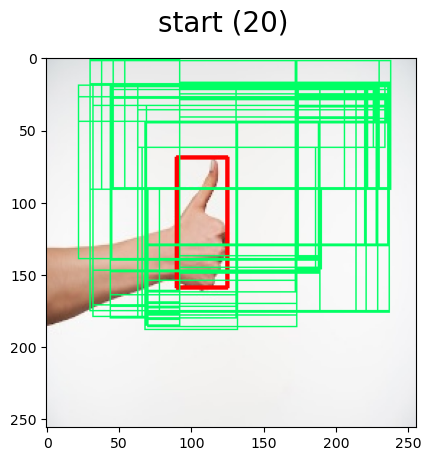

In [103]:
img_name = "start (20)"
img_path = rdir_imgs+"/start/"+img_name+".jpg"
bbox_path = dir_bboxes+"/"+img_name+".txt"
plot_img_w_bbox_and_adjusted_aboxes(img_path, bbox_path, roi_sorted, 100)